In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [7]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [9]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [12]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Moving Average and Donchian Channel

In [165]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [16]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [18]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [20]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [22]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [24]:
# def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

#     log_price_col = f'{ticker}_t_1_close_price_log'
#     df[log_price_col] = np.log(df[t_1_close_price_col])
    
#     ## Define the variables
#     y = df[log_price_col]
#     x = np.arange(len(y), dtype=float) # Time

#     ## Compute rolling sums for rolling R2 calculation
#     x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
#     y_sum = y.rolling(r2_window).sum()
#     x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
#     y_sqr = (y**2).rolling(r2_window).sum()
#     xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

#     ## Calculate the R squared
#     n = r2_window
#     numerator = n * xy_sum - x_sum * y_sum
#     denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
#     df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

#     ## Normalize the R Squared centered around 0.5 where values below the lower limit are
#     ## clipped to 0 and values above 0.8 are clipped to 1
#     df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

#     return df

In [26]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    # z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
    #      slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())
    # Removing the Min Period, the Z-Score will be calculated when the mavg_z_score_window history is available
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).std())
    

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [28]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [30]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                           use_activation=True, tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date

        df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=run_date, end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [32]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, 
                                                                entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window=4,
                                                                use_activation=True, tanh_activation_constant_dict=None,
                                                                moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                       entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                       use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc, 
                                                       use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [34]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Moving Average Ribbon and Donchian Channel Breakout Parameter Optimization

In [37]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.9
donchian_signal_weight = 0.1
weighted_signal_ewm_window = 4
use_activation = False
tanh_activation_constant_dict = None
rolling_r2_window = 100
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.90
r2_smooth_window = 3
r2_confirm_days = 0
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
use_specific_start_date = True
signal_start_date = pd.Timestamp('2022-04-01').date()

In [62]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2025-07-31
warm_up_days                  : 285
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.9

entry_rolling_donchian_window : 56
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.1

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6

lower_r_sqr_limit   

In [41]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
df_final = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)
df_final = df_final[df_final.index >= start_date]
df_final = calculate_asset_level_returns(df_final, end_date=end_date, ticker_list=ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [42]:
calculate_risk_and_performance_metrics(df_final, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                       strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                       passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

{'annualized_return': 0.07935257431173559,
 'annualized_sharpe_ratio': 0.2787607893122489,
 'calmar_ratio': 0.13113754900678962,
 'annualized_std_dev': 0.5605445182529785,
 'max_drawdown': -0.60510948170632,
 'max_drawdown_duration': Timedelta('680 days 00:00:00'),
 'hit_rate': 0.3226600985221675,
 't_statistic': 0.7164722758314328,
 'p_value': 0.4738372434244257,
 'trade_count': 1522.0}

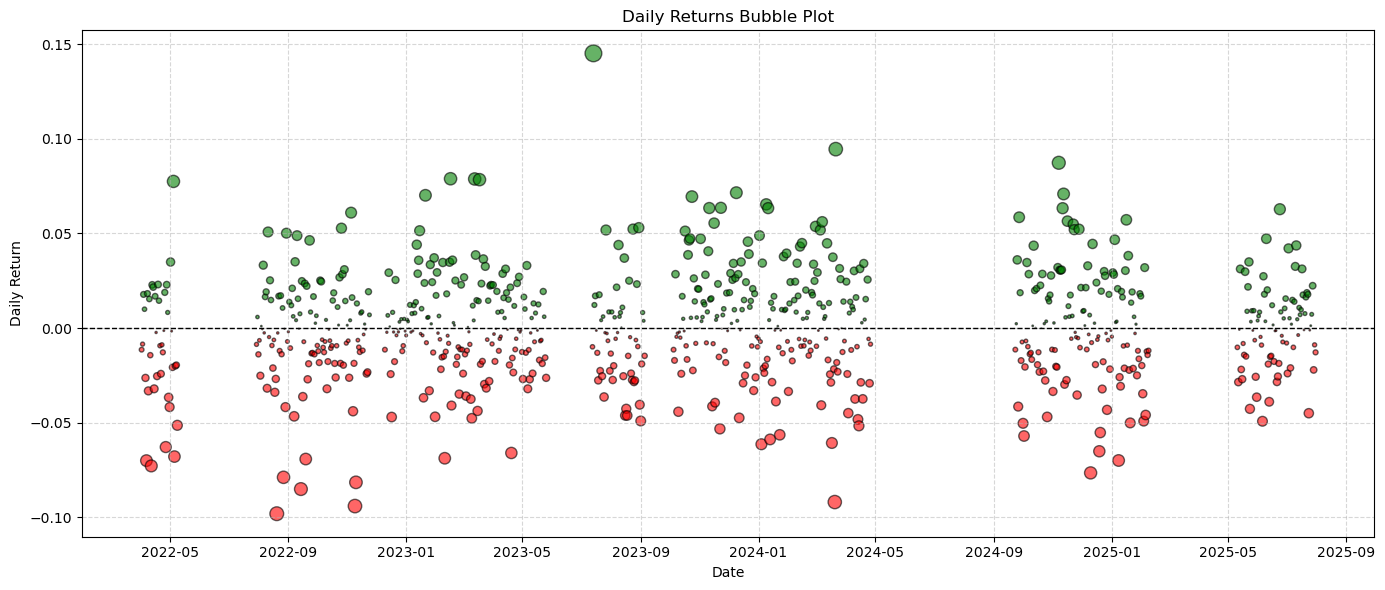

In [43]:
perf.plot_daily_returns_bubble(df_final[(df_final.index >= pd.Timestamp(start_date).date())], return_col='portfolio_daily_pct_returns')

<Axes: xlabel='date'>

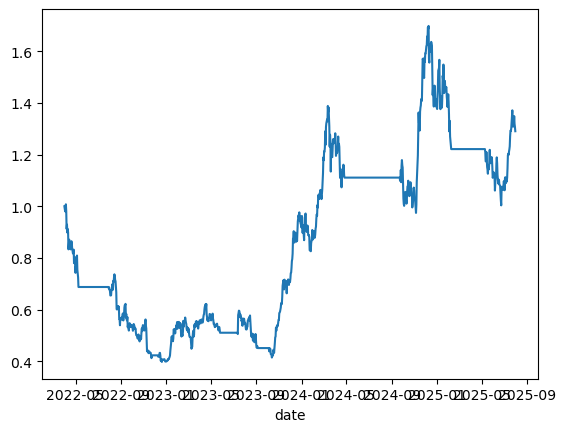

In [44]:
df_final['equity_curve'].plot()

<Axes: xlabel='date'>

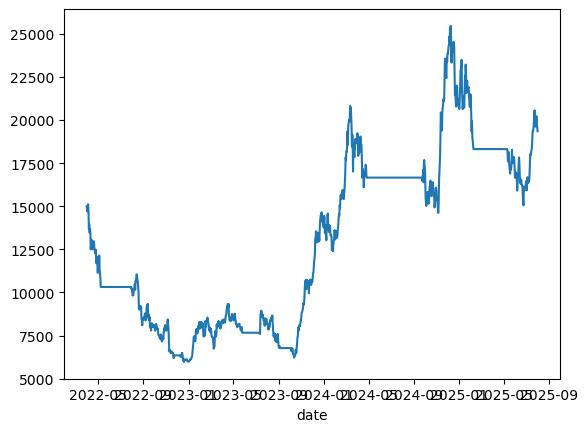

In [45]:
df_final['total_portfolio_value'].plot()

## Add Rolling R Squared Filter

### 📘 Pearson Correlation Coefficient Formula

The Pearson correlation coefficient \( r \) is given by:

$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
         {\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

Where:

- \( x_i, y_i \) are individual data points  
- \( \bar{x}, \bar{y} \) are the sample means of \( x \) and \( y \)  
- \( n \) is the number of observations


### 📘 Simplified Pearson Correlation Formula (Using Raw Sums)

The Pearson correlation coefficient \( r \) can also be written as:

$$
r = \frac{n \sum x_i y_i - \sum x_i \sum y_i}
         {\sqrt{n \sum x_i^2 - (\sum x_i)^2} \cdot \sqrt{n \sum y_i^2 - (\sum y_i)^2}}
$$

Where:

- \( x_i, y_i \) are the data values  
- \( n \) is the number of observations  
- \( \sum x_i y_i \) is the sum of the elementwise products  
- \( \sum x_i \), \( \sum y_i \) are the sums of each series  
- \( \sum x_i^2 \), \( \sum y_i^2 \) are the sums of squares


In [64]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sqr = (y**2).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    ## Smoothing the Rolling R Squared Signal
    if r2_smooth_window >= 1:
        df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].ewm(span=r2_smooth_window, adjust=False).mean()

    ## Adding Convex Scaling to further reduce the signal during low trends and amplify during high trends
    # df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].clip(0, 1) ** 1.5

    return df

In [66]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                                              exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                                              rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                                              use_activation=True, tanh_activation_constant_dict=None, 
                                                                              moving_avg_type='exponential', price_or_returns_calc='price',
                                                                              long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])
    
    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[donchian_binary_signal_col]
        
    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, rolling_r2_window=rolling_r2_window,
                                    lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window)

    ## Apply Regime Filters
    # Introduce a 3-day confirmation period for Rolling R Squared Signal
    if r2_confirm_days >= 1:
        df_trend[f'{ticker}_r2_enable'] = (df_trend[f'{ticker}_rolling_r_sqr'] > 0.5).rolling(r2_confirm_days, min_periods=r2_confirm_days).min().fillna(0.0).astype(float)
        df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_r2_enable']
    else:
        df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_rolling_r_sqr']
    
    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]), df_trend[final_signal_col])

    return df_trend

def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                               exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                               rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                               use_activation=True, tanh_activation_constant_dict=None, 
                                                               moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                               use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        # rolling_r2_enable_col = f'{ticker}_r2_enable'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date
            
        df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [68]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, 
                                                                                   entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                                   ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window=4,
                                                                                   rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                                                   use_activation=True, tanh_activation_constant_dict=None,
                                                                                   moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                                                   initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                                   rolling_atr_window=20, atr_multiplier=0.5,
                                                                                   transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                                   use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', 
                                                                                   rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                                   annual_trading_days=365, use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                          slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                                          entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                                          use_donchian_exit_gate=use_donchian_exit_gate,
                                                                          ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                                                                          rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                          r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                                                                          use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                                          moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc, 
                                                                          use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [70]:
rolling_r2_window=30; lower_r_sqr_limit=0.2; upper_r_sqr_limit=0.8; 
## Check if data is available for all the tickers
date_list = cn.coinbase_start_date_by_ticker_dict
ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

print('Generating Moving Average Ribbon Signal!!')
## Generate Trend Signal for all tickers
df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                      slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                                      entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                                      use_donchian_exit_gate=use_donchian_exit_gate,
                                                                      ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                                                                      rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0,
                                                                      use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                                      moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc, 
                                                                      use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

Generating Moving Average Ribbon Signal!!


<Axes: xlabel='date'>

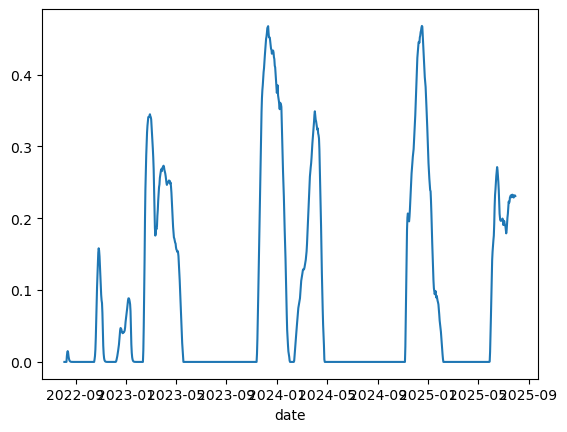

In [72]:
df_trend['BTC-USD_final_signal'].plot()

In [74]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, 
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)
df_final = df_final[df_final.index >= start_date]
df_final = calculate_asset_level_returns(df_final, end_date=end_date, ticker_list=ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [75]:
calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                       strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                       passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

{'annualized_return': -0.004156521585433115,
 'annualized_sharpe_ratio': 0.08504418437459497,
 'calmar_ratio': -0.0066618741434111214,
 'annualized_std_dev': 0.5701236687241779,
 'max_drawdown': -0.6239267653448681,
 'max_drawdown_duration': Timedelta('696 days 00:00:00'),
 'hit_rate': 0.28405797101449276,
 't_statistic': 0.3898980456959389,
 'p_value': 0.6966721495031412,
 'trade_count': 2253.0}

## Walk Forward Analysis for Rolling R Squared

In [77]:
import itertools

def generate_rolling_r_sqr_params():
    parameter_grid = {
        "rolling_r2_window": [14, 20, 30, 50, 80, 100, 126],
        "lower_r_sqr_limit": [0.15, 0.25, 0.35, 0.45],
        "upper_r_sqr_limit": [0.60, 0.75, 0.80, 0.90]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [78]:
def run_walk_forward_rolling_r_sqr(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                   entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                   ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'rolling_r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_rolling_r_sqr_params():
            print(params)
            rolling_r2_window = params['rolling_r2_window']
            lower_r_sqr_limit = params['lower_r_sqr_limit']
            upper_r_sqr_limit = params['upper_r_sqr_limit']
            
            print(rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'rolling_r2_window': rolling_r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        walk_forward_run_cond = in_sample_cond & date_cond

        ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        best_rolling_r2_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['rolling_r2_window'].iloc[0]
        best_lower_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['lower_r_sqr_limit'].iloc[0]
        best_upper_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['upper_r_sqr_limit'].iloc[0]
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
            use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=best_rolling_r2_window, lower_r_sqr_limit=best_lower_r_sqr_limit, upper_r_sqr_limit=best_upper_r_sqr_limit,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
        
        ## Out of Sample Performance Metrics
        print('Pulling Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'rolling_r2_window': best_rolling_r2_window,
            'lower_r_sqr_limit': best_lower_r_sqr_limit,
            'upper_r_sqr_limit': best_upper_r_sqr_limit
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [79]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-10-01').date()
start_date = pd.Timestamp(start_date).date()
end_date = pd.Timestamp(end_date).date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'rolling_r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count', 'ticker_sharpe_mean', 'ticker_sharpe_std', 'turnover', 'rolling_r2_score']
ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    ## Break Condition for While loop
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    if end_date_os > last_available_date:
        print('end_date_os > last_available_date')
        end_date_os = last_available_date
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
    
    print("Run Dates: ")
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))

    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS s

In [135]:
%%time
df_performance_rolling_r2_1 = run_walk_forward_rolling_r_sqr(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                             entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                             ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.6}
14 0.15 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.75}
14 0.15 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average T

In [136]:
df_performance_rolling_r2_1

sampling_category  start_date    end_date  rolling_r2_window  \
0           in_sample  2022-04-01  2023-09-30                 14   
1           in_sample  2022-04-01  2023-09-30                 14   
2           in_sample  2022-04-01  2023-09-30                 14   
3           in_sample  2022-04-01  2023-09-30                 14   
4           in_sample  2022-04-01  2023-09-30                 14   
5           in_sample  2022-04-01  2023-09-30                 14   
6           in_sample  2022-04-01  2023-09-30                 14   
7           in_sample  2022-04-01  2023-09-30                 14   
8           in_sample  2022-04-01  2023-09-30                 14   
9           in_sample  2022-04-01  2023-09-30                 14   
10          in_sample  2022-04-01  2023-09-30                 14   
11          in_sample  2022-04-01  2023-09-30                 14   
12          in_sample  2022-04-01  2023-09-30                 14   
13          in_sample  2022-04-01  2023-09-30                 14   
14          in_sample  2022-04-01  2023-09-30                 14   
15          in_sample  2022-04-01  2023-09-30                 14   
16          in_sample  2022-04-01  2023-09-30                 20   
17          in_sample  2022-04-01  2023-09-30                 20   
18          in_sample  2022-04-01  2023-09-30                 20   
19          in_sample  2022-04-01  2023-09-30                 20   
20          in_sample  2022-04-01  2023-09-30                 20   
21          in_sample  2022-04-01  2023-09-30                 20   
22          in_sample  2022-04-01  2023-09-30                 20   
23          in_sample  2022-04-01  2023-09-30                 20   
24          in_sample  2022-04-01  2023-09-30                 20   
25          in_sample  2022-04-01  2023-09-30                 20   
26          in_sample  2022-04-01  2023-09-30                 20   
27          in_sample  2022-04-01  2023-09-30                 20   
28          in_sample  2022-04-01  2023-09-30                 20   
29          in_sample  2022-04-01  2023-09-30                 20   
30          in_sample  2022-04-01  2023-09-30                 20   
31          in_sample  2022-04-01  2023-09-30                 20   
32          in_sample  2022-04-01  2023-09-30                 30   
33          in_sample  2022-04-01  2023-09-30                 30   
34          in_sample  2022-04-01  2023-09-30                 30   
35          in_sample  2022-04-01  2023-09-30                 30   
36          in_sample  2022-04-01  2023-09-30                 30   
37          in_sample  2022-04-01  2023-09-30                 30   
38          in_sample  2022-04-01  2023-09-30                 30   
39          in_sample  2022-04-01  2023-09-30                 30   
40          in_sample  2022-04-01  2023-09-30                 30   
41          in_sample  2022-04-01  2023-09-30                 30   
42          in_sample  2022-04-01  2023-09-30                 30   
43          in_sample  2022-04-01  2023-09-30                 30   
44          in_sample  2022-04-01  2023-09-30                 30   
45          in_sample  2022-04-01  2023-09-30                 30   
46          in_sample  2022-04-01  2023-09-30                 30   
47          in_sample  2022-04-01  2023-09-30                 30   
48          in_sample  2022-04-01  2023-09-30                 50   
49          in_sample  2022-04-01  2023-09-30                 50   
50          in_sample  2022-04-01  2023-09-30                 50   
51          in_sample  2022-04-01  2023-09-30                 50   
52          in_sample  2022-04-01  2023-09-30                 50   
53          in_sample  2022-04-01  2023-09-30                 50   
54          in_sample  2022-04-01  2023-09-30                 50   
55          in_sample  2022-04-01  2023-09-30                 50   
56          in_sample  2022-04-01  2023-09-30                 50   
57          in_sample  2022-04-01  2023-09-30               

In [137]:
df_performance_rolling_r2_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2022-04-01-2024-04-01.pickle')

In [138]:
%%time
df_performance_rolling_r2_2 = run_walk_forward_rolling_r_sqr(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                             entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                             ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.6}
14 0.15 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.75}
14 0.15 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average T

In [139]:
df_performance_rolling_r2_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2022-10-01-2024-10-01.pickle')

In [140]:
%%time
df_performance_rolling_r2_3 = run_walk_forward_rolling_r_sqr(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                             entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                             ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.6}
14 0.15 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.75}
14 0.15 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average T

In [141]:
df_performance_rolling_r2_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2023-04-01-2025-04-01.pickle')

In [142]:
%%time
df_performance_rolling_r2_4 = run_walk_forward_rolling_r_sqr(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                             entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                             ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.6}
14 0.15 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'rolling_r2_window': 14, 'lower_r_sqr_limit': 0.15, 'upper_r_sqr_limit': 0.75}
14 0.15 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjuste

In [143]:
df_performance_rolling_r2_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2023-10-01-2025-10-01.pickle')

In [153]:
df_performance_rolling_r2 = pd.concat([df_performance_rolling_r2_1, df_performance_rolling_r2_2,
                                       df_performance_rolling_r2_3, df_performance_rolling_r2_4], axis=0, ignore_index=True)

In [155]:
df_performance_rolling_r2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2022-04-01-2025-10-01.pickle')

### Analyze Walk Forward Results from Rolling R Squared

In [95]:
df_performance_rolling_r2 = pd.read_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2022-04-01-2025-10-01.pickle')

In [97]:
df_performance_rolling_r2_is = df_performance_rolling_r2[df_performance_rolling_r2.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_rolling_r2_os = df_performance_rolling_r2[df_performance_rolling_r2.sampling_category == 'out_sample'].reset_index(drop=True)

In [99]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}

In [105]:
# ## Best In Sample Perforamance by Fold
# df_best_score_per_fold_is = df_performance_rolling_r2_is.groupby(['start_date','end_date']).agg(agg_dict).reset_index()
# perf_cols = ['rolling_r2_score','rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','annualized_sharpe_ratio','annualized_std_dev','max_drawdown','trade_count']
# df_best_score_per_fold_is = pd.merge(df_best_score_per_fold_is, df_performance_rolling_r2_is[perf_cols], on='rolling_r2_score',how='inner')
# df_best_score_per_fold_is

In [107]:
df_performance_rolling_r2_os

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-10-01  2024-03-31                100   
1        out_sample  2024-04-01  2024-09-30                126   
2        out_sample  2024-10-01  2025-03-31                126   
3        out_sample  2025-04-01  2025-07-31                100   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0               0.45                0.9           0.754504   
1               0.15                0.9          -0.069894   
2               0.15                0.9           0.037346   
3               0.25                0.9           0.042860   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 1.791767      4.146337            0.591695     -0.181969   
1                -0.836694     -0.449353            0.554462     -0.155543   
2                 0.092228      0.145114            0.542099     -0.257358   
3                 0.016397      0.217895            0.376415     -0.196700   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              323 days  0.175258     2.244515  0.025250        299.0   
1              309 days  0.032990    -0.545076  0.585952         43.0   
2              307 days  0.128099     0.311660  0.755433        238.0   
3              341 days  0.101415     0.406756  0.684393         77.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.114914                   0.216032   
1                  -0.031339                  -0.031050   
2                   0.166789                  -0.007681   
3                   0.048478                   0.073538   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   0.093085                   0.132412   
1                  -0.009709                   0.009139   
2                  -0.044711                  -0.005523   
3                   0.003058                   0.000000   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.136989                         0.617686   
1                    0.029385                        -1.026853   
2                    0.019259                         0.954060   
3                   -0.013330                         0.018425   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         1.215048                         0.533397   
1                        -2.017102                        -5.659033   
2                        -1.121604                        -2.565562   
3                         0.392582                        -1.333190   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         1.007821                          0.987882   
1                        -2.391760                         -0.299244   
2                        -0.324142                         -0.510961   
3                             -inf                         -5.812817   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.210551                    0.245516   
1                    0.346024                    0.218476   
2                    0.262650                    0.129472   
3                    0.189727                    0.166117   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.166570                    0.182780   
1                    0.071315                    0.174314   
2                    0.099147                    0.283263   
3                    0.113026                         NaN   

   AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
0                     0.191066             -0.052472             -0.127634   
1                     0.490207             -0.096664             -0.058369   
2                     0.142827             -0.050619             -0.056496   
3                     0.073270         

In [109]:
## Overall Out of Sample Stats
df_performance_rolling_r2_is.groupby(['rolling_r2_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
rolling_r2_window                                               
126                              0.978254  0.663896  0.742160   
100                              0.939202  0.603675  0.784023   
50                               0.959310  0.484024  0.982255   
80                               0.717011  0.364149  0.768021   
30                               0.626694  0.209947  0.945099   
20                               0.356584 -0.113585  0.967079   
14                              -0.232468 -0.604335  0.982530   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
rolling_r2_window                                                      
126                        0.346473  0.263670  0.291370    -0.356464   
100                        0.352633  0.251375  0.283263    -0.337942   
50                         0.361237  0.226123  0.355046    -0.368290   
80                         0.245978  0.151641  0.261842    -0.330252   
30                         0.224605  0.105532  0.317722    -0.406735   
20                         0.118078 -0.015128  0.294502    -0.443522   
14                        -0.091807 -0.170432  0.255690    -0.529890   

                                      trade_count                          \
                       mean       std      median        mean         std   
rolling_r2_window                                                           
126               -0.367786  0.122010       538.5  546.937500  117.666043   
100               -0.350202  0.121737       519.0  522.718750  139.008447   
50                -0.397423  0.122642       605.5  607.640625  126.814997   
80                -0.366205  0.111093       548.5  554.906250  141.437711   
30                -0.450995  0.136441       631.5  663.453125  127.849854   
20                -0.494658  0.157827       710.5  742.843750  163.904174   
14                -0.568709  0.163160       803.0  812.734375  180.867683   

                  BTC-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
126                                      0.110792  0.319053  0.398862   
100                                      0.565362  0.413848  0.467929   
50                                       0.227651  0.059018  0.696054   
80                                       0.588235  0.440770  0.426782   
30                                       0.102835 -0.131353  0.761686   
20                                       0.139502  0.141284  0.364047   
14                                      -0.119711 -0.075176  0.300934   

                  ETH-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
126                                      0.381041  0.377102  0.369672   
100                                      0.468110  0.291732  0.563796   
50                                      -0.228414 -0.364867  0.342022   
80                                       0.591482  0.354722  0.598333   
30                                       0.367097  0.150160  0.498000   
20                                       0.643976  0.480176  0.577686   
14                                       1.391729  0.948106  0.918723   

                  SOL-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
126                                     -0.073456 -0.095784  0.337380   
100                                     -0.078962 -0.006589  0.717603   
50                                       0.74938

In [111]:
## Overall Out of Sample Stats
df_performance_rolling_r2_os.groupby(['rolling_r2_window']).agg(agg_dict)

annualized_sharpe_ratio                      \
                                   median      mean       std   
rolling_r2_window                                               
100                              0.904082  0.904082  1.255376   
126                             -0.372233 -0.372233  0.656847   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
rolling_r2_window                                                      
100                        0.398682  0.398682  0.503208    -0.189334   
126                       -0.016274 -0.016274  0.075830    -0.206450   

                                      trade_count                     \
                       mean       std      median   mean         std   
rolling_r2_window                                                      
100               -0.189334  0.010416       188.0  188.0  156.977705   
126               -0.206450  0.071994       140.5  140.5  137.885822   

                  BTC-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
100                                      0.318055  0.318055  0.423742   
126                                     -0.036396 -0.036396  1.400717   

                  ETH-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
100                                      0.803815  0.803815  0.581571   
126                                     -1.569353 -1.569353  0.633212   

                  SOL-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
100                                     -0.399897 -0.399897  1.319876   
126                                     -4.112297 -4.112297  2.187414   

                  ADA-USD_annualized_sharpe_ratio                      \
                                           median      mean       std   
rolling_r2_window                                                       
100                                          -inf      -inf       NaN   
126                                     -1.357951 -1.357951  1.462027   

                  AVAX-USD_annualized_sharpe_ratio                      
                                            median      mean       std  
rolling_r2_window                                                       
100                                      -2.412468 -2.412468  4.808821  
126                                      -0.405103 -0.405103  0.149706

In [175]:
df_performance_rolling_r2_is.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit']).agg(agg_dict).reset_index().sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit  \
                                                            
99                126              0.15              0.90   
98                126              0.15              0.80   
97                126              0.15              0.75   
96                126              0.15              0.60   
90                100              0.35              0.80   
91                100              0.35              0.90   
89                100              0.35              0.75   
88                100              0.35              0.60   
103               126              0.25              0.90   
102               126              0.25              0.80   
101               126              0.25              0.75   
100               126              0.25              0.60   
94                100              0.45              0.80   
93                100              0.45              0.75   
95                100              0.45              0.90   
92                100              0.45              0.60   
59                 50              0.35              0.90   
56                 50              0.35              0.60   
58                 50              0.35              0.80   
57                 50              0.35              0.75   
52                 50              0.25              0.60   
55                 50              0.25              0.90   
54                 50              0.25              0.80   
53                 50              0.25              0.75   
107               126              0.35              0.90   
106               126              0.35              0.80   
105               126              0.35              0.75   
86                100              0.25              0.80   
87                100              0.25              0.90   
85                100              0.25              0.75   
104               126              0.35              0.60   
84                100              0.25              0.60   
111               126              0.45              0.90   
110               126              0.45              0.80   
109               126              0.45              0.75   
48                 50              0.15              0.60   
108               126              0.45              0.60   
81                100              0.15              0.75   
50                 50              0.15              0.80   
51                 50              0.15              0.90   
82                100              0.15              0.80   
49                 50              0.15              0.75   
80                100              0.15              0.60   
83                100              0.15              0.90   
70                 80              0.25              0.80   
69                 80              0.25              0.75   
71                 80              0.25              0.90   
68                 80              0.25              0.60   
79                 80              0.45              0.90   
78                 80              0.45              0.80   
77                 80              0.45              0.75   
76                 80              0.45              0.60   
65                 80              0.15              0.75   
66                 80              0.15              0.80   
67                 80              0.15              0.90   
64                 80              0.15              0.60   
45                 30              0.45              0.75   
46                 30              0.45              0.80   
63                 50              0.45              0.90   
60                 50              0.45              0.60   
47                 30              0.45              0.90   
74                 80              0.35              0.80   
75                 80              0.35              0.90   
62                 50              0.45

In [177]:
df_performance_rolling_r2_os.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit']).agg(agg_dict).reset_index().sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit  \
                                                          
1               100              0.45               0.9   
0               100              0.25               0.9   
2               126              0.15               0.9   

  annualized_sharpe_ratio                     annualized_return            \
                   median      mean       std            median      mean   
1                1.791767  1.791767       NaN          0.754504  0.754504   
0                0.016397  0.016397       NaN          0.042860  0.042860   
2               -0.372233 -0.372233  0.656847         -0.016274 -0.016274   

           max_drawdown                     trade_count                     \
       std       median      mean       std      median   mean         std   
1      NaN    -0.181969 -0.181969       NaN       299.0  299.0         NaN   
0      NaN    -0.196700 -0.196700       NaN        77.0   77.0         NaN   
2  0.07583    -0.206450 -0.206450  0.071994       140.5  140.5  137.885822   

  BTC-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
1                        0.617686  0.617686       NaN   
0                        0.018425  0.018425       NaN   
2                       -0.036396 -0.036396  1.400717   

  ETH-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
1                        1.215048  1.215048       NaN   
0                        0.392582  0.392582       NaN   
2                       -1.569353 -1.569353  0.633212   

  SOL-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
1                        0.533397  0.533397       NaN   
0                       -1.333190 -1.333190       NaN   
2                       -4.112297 -4.112297  2.187414   

  ADA-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
1                        1.007821  1.007821       NaN   
0                            -inf      -inf       NaN   
2                       -1.357951 -1.357951  1.462027   

  AVAX-USD_annualized_sharpe_ratio                      
                            median      mean       std  
1                         0.987882  0.987882       NaN  
0                        -5.812817 -5.812817       NaN  
2                        -0.405103 -0.405103  0.149706

In [179]:
df_performance_rolling_r2_is[(df_performance_rolling_r2_is.rolling_r2_window == 100) & (df_performance_rolling_r2_is.lower_r_sqr_limit == 0.45) & (df_performance_rolling_r2_is.upper_r_sqr_limit == 0.90)]

sampling_category  start_date    end_date  rolling_r2_window  \
95          in_sample  2022-04-01  2023-09-30                100   
207         in_sample  2022-10-01  2024-03-31                100   
319         in_sample  2023-04-01  2024-09-30                100   
431         in_sample  2023-10-01  2025-03-31                100   

     lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
95                0.45                0.9          -0.049380   
207               0.45                0.9           0.381449   
319               0.45                0.9           0.297860   
431               0.45                0.9           0.332417   

     annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
95                 -0.232763     -0.139705            0.589749     -0.353456   
207                 0.983495      1.078020            0.595553     -0.353842   
319                 0.926595      1.371973            0.566227     -0.217103   
431                 0.929327      1.523848            0.571023     -0.218143   

    max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
95               282 days  0.129577    -0.072207  0.942457        297.0   
207              318 days  0.203529     1.721948  0.085443        573.0   
319              311 days  0.144536     1.693777  0.090674        373.0   
431              323 days  0.170588     1.660828  0.097117        526.0   

     BTC-USD_annualized_return  ETH-USD_annualized_return  \
95                    0.151304                   0.020904   
207                   0.195315                   0.156121   
319                   0.029522                   0.102382   
431                   0.117486                   0.090953   

     SOL-USD_annualized_return  ADA-USD_annualized_return  \
95                   -0.047660                  -0.000085   
207                   0.012390                   0.080039   
319                   0.047478                   0.090363   
431                   0.038057                   0.061494   

     AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
95                    -0.024401                         0.871067   
207                    0.036926                         1.057678   
319                    0.076746                        -0.118368   
431                    0.084882                         0.514526   

     ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
95                         -0.234508                        -1.632075   
207                         0.911145                        -0.397674   
319                         0.514991                        -0.007176   
431                         0.416550                        -0.119394   

     ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
95                         -0.531636                         -0.753221   
207                         0.333112                         -0.065905   
319                         0.608632                          0.424736   
431                         0.183787                          0.503660   

     BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
95                     0.237450                    0.245296   
207                    0.224891                    0.213113   
319                    0.234130                    0.222176   
431                    0.263547                    0.215677   

     SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
95                     0.182941                    0.324125   
207                    0.178823                    0.246682   
319                    0.161048                    0.191820   
431                    0.161246                    0.174422   

     AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
95                      0.275340             -0.073219             -0.112837   
207                     0.237112             -0.082220             -0.126482   
319

## Generate Rolling R Squared Out of Sample Performance for Locked Rolling R Squared Config

In [113]:
import itertools

def generate_rolling_r_sqr_smooth_days_r2_confirm_params():
    parameter_grid = {
        "rolling_r2_window": [100],
        "lower_r_sqr_limit": [0.45],
        "upper_r_sqr_limit": [0.90],
        "r2_smooth_window": [0, 2, 3, 5, 8],
        "r2_confirm_days": [0, 2, 3, 5]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [115]:
def run_walk_forward_rolling_r_sqr_smooth_days_r2_confirm(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                          entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                          ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'rolling_r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'r2_smooth_window', 'r2_confirm_days', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_rolling_r_sqr_smooth_days_r2_confirm_params():
            print(params)
            rolling_r2_window = params['rolling_r2_window']
            lower_r_sqr_limit = params['lower_r_sqr_limit']
            upper_r_sqr_limit = params['upper_r_sqr_limit']
            r2_smooth_window = params['r2_smooth_window']
            r2_confirm_days = params['r2_confirm_days']
            
            print(rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit, r2_smooth_window, r2_confirm_days)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'rolling_r2_window': rolling_r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit,
                'r2_smooth_window': r2_smooth_window,
                'r2_confirm_days': r2_confirm_days
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_rolling_r2_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['rolling_r2_window'].iloc[0]
        # best_lower_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['lower_r_sqr_limit'].iloc[0]
        # best_upper_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['upper_r_sqr_limit'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'rolling_r2_window': rolling_r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit,
                'r2_smooth_window': r2_smooth_window,
                'r2_confirm_days': r2_confirm_days
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [342]:
%%time
df_performance_rolling_r2_smooth_window_confirm_1 = run_walk_forward_rolling_r_sqr_smooth_days_r2_confirm(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                        entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                        ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'rolling_r2_window': 100, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.9, 'r2_smooth_window': 0, 'r2_confirm_days': 0}
100 0.45 0.9 0 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [343]:
df_performance_rolling_r2_smooth_window_confirm_1

sampling_category  start_date    end_date  rolling_r2_window  \
0          in_sample  2022-04-01  2023-09-30                100   
1         out_sample  2023-10-01  2024-03-31                100   
2          in_sample  2022-04-01  2023-09-30                100   
3         out_sample  2023-10-01  2024-03-31                100   
4          in_sample  2022-04-01  2023-09-30                100   
5         out_sample  2023-10-01  2024-03-31                100   
6          in_sample  2022-04-01  2023-09-30                100   
7         out_sample  2023-10-01  2024-03-31                100   
8          in_sample  2022-04-01  2023-09-30                100   
9         out_sample  2023-10-01  2024-03-31                100   
10         in_sample  2022-04-01  2023-09-30                100   
11        out_sample  2023-10-01  2024-03-31                100   
12         in_sample  2022-04-01  2023-09-30                100   
13        out_sample  2023-10-01  2024-03-31                100   
14         in_sample  2022-04-01  2023-09-30                100   
15        out_sample  2023-10-01  2024-03-31                100   
16         in_sample  2022-04-01  2023-09-30                100   
17        out_sample  2023-10-01  2024-03-31                100   
18         in_sample  2022-04-01  2023-09-30                100   
19        out_sample  2023-10-01  2024-03-31                100   
20         in_sample  2022-04-01  2023-09-30                100   
21        out_sample  2023-10-01  2024-03-31                100   
22         in_sample  2022-04-01  2023-09-30                100   
23        out_sample  2023-10-01  2024-03-31                100   
24         in_sample  2022-04-01  2023-09-30                100   
25        out_sample  2023-10-01  2024-03-31                100   
26         in_sample  2022-04-01  2023-09-30                100   
27        out_sample  2023-10-01  2024-03-31                100   
28         in_sample  2022-04-01  2023-09-30                100   
29        out_sample  2023-10-01  2024-03-31                100   
30         in_sample  2022-04-01  2023-09-30                100   
31        out_sample  2023-10-01  2024-03-31                100   
32         in_sample  2022-04-01  2023-09-30                100   
33        out_sample  2023-10-01  2024-03-31                100   
34         in_sample  2022-04-01  2023-09-30                100   
35        out_sample  2023-10-01  2024-03-31                100   
36         in_sample  2022-04-01  2023-09-30                100   
37        out_sample  2023-10-01  2024-03-31                100   
38         in_sample  2022-04-01  2023-09-30                100   
39        out_sample  2023-10-01  2024-03-31                100   

    lower_r_sqr_limit  upper_r_sqr_limit  r2_smooth_window  r2_confirm_days  \
0                0.45                0.9                 0                0   
1                0.45                0.9                 0                0   
2                0.45                0.9                 0                2   
3                0.45                0.9                 0                2   
4                0.45                0.9                 0                3   
5                0.45                0.9                 0                3   
6                0.45                0.9                 0                5   
7                0.45                0.9                 0                5   
8                0.45                0.9                 2                0   
9                0.45                0.9                 2                0   
10               0.45                0.9                 2                2   
11               0.45                0.9                 2                2   
12               0.45                0.9                 2                3   
13               0.45                0.9                 2                3   
14               0.45                0.9                 2            

In [344]:
df_performance_rolling_r2_smooth_window_confirm_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Smooth_Confirm_Days_Performance-2022-04-01-2024-04-01.pickle')

In [345]:
%%time
df_performance_rolling_r2_smooth_window_confirm_2 = run_walk_forward_rolling_r_sqr_smooth_days_r2_confirm(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                        entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                        ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'rolling_r2_window': 100, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.9, 'r2_smooth_window': 0, 'r2_confirm_days': 0}
100 0.45 0.9 0 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [346]:
df_performance_rolling_r2_smooth_window_confirm_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Smooth_Confirm_Days_Performance-2022-10-01-2024-10-01.pickle')

In [347]:
%%time
df_performance_rolling_r2_smooth_window_confirm_3 = run_walk_forward_rolling_r_sqr_smooth_days_r2_confirm(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                        entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                        ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'rolling_r2_window': 100, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.9, 'r2_smooth_window': 0, 'r2_confirm_days': 0}
100 0.45 0.9 0 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [348]:
df_performance_rolling_r2_smooth_window_confirm_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Smooth_Confirm_Days_Performance-2023-04-01-2025-04-01.pickle')

In [349]:
%%time
df_performance_rolling_r2_smooth_window_confirm_4 = run_walk_forward_rolling_r_sqr_smooth_days_r2_confirm(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                        entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                        ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'rolling_r2_window': 100, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.9, 'r2_smooth_window': 0, 'r2_confirm_days': 0}
100 0.45 0.9 0 0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True 

In [350]:
df_performance_rolling_r2_smooth_window_confirm_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Smooth_Confirm_Days_Performance-2023-10-01-2025-10-01.pickle')

In [390]:
df_performance_rolling_r2_smooth_window_confirm = pd.concat([df_performance_rolling_r2_smooth_window_confirm_1, df_performance_rolling_r2_smooth_window_confirm_2,
                                                             df_performance_rolling_r2_smooth_window_confirm_3, df_performance_rolling_r2_smooth_window_confirm_4], axis=0)

In [392]:
df_performance_rolling_r2_smooth_window_confirm.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Smooth_Confirm_Days_Performance-2022-04-01-2025-10-01.pickle')

In [394]:
in_sample_cond = (df_performance_rolling_r2_smooth_window_confirm.sampling_category == 'in_sample')
df_performance_rolling_r2_smooth_window_confirm_is = df_performance_rolling_r2_smooth_window_confirm[in_sample_cond].reset_index(drop=True)
df_performance_rolling_r2_smooth_window_confirm_os = df_performance_rolling_r2_smooth_window_confirm[~in_sample_cond].reset_index(drop=True)

In [398]:
df_performance_rolling_r2_smooth_window_confirm_is.groupby(['r2_smooth_window','r2_confirm_days']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                                  median      mean       std   
r2_smooth_window r2_confirm_days                                               
3                0                              1.275666  0.862727  0.887212   
2                0                              1.273874  0.843725  0.921309   
0                0                              0.927961  0.651663  0.590199   
5                0                              0.996691  0.566839  0.961375   
8                0                              0.792684  0.411574  0.956013   
0                2                              0.309864  0.332112  0.372478   
                 5                              0.248139  0.289361  0.308960   
                 3                              0.239251  0.258270  0.339742   
8                5                              0.200684  0.250048  0.212968   
2                3                              0.215230  0.237522  0.354304   
3                5                              0.204010  0.236804  0.291748   
                 3                              0.196859  0.233304  0.280492   
8                2                              0.150334  0.221906  0.226422   
2                2                              0.192135  0.219196  0.335107   
                 5                              0.176111  0.216712  0.300922   
5                3                              0.149703  0.211530  0.228246   
8                3                              0.127146  0.200355  0.213555   
3                2                              0.180643  0.186752  0.341755   
5                5                              0.101605  0.181651  0.190940   
                 2                              0.132102  0.170376  0.261407   

                                 annualized_return                      \
                                            median      mean       std   
r2_smooth_window r2_confirm_days                                         
3                0                        0.501097  0.366736  0.377812   
2                0                        0.501461  0.369373  0.373692   
0                0                        0.315138  0.240587  0.196329   
5                0                        0.405781  0.239399  0.382963   
8                0                        0.310468  0.171906  0.365333   
0                2                        0.106755  0.122822  0.124564   
                 5                        0.086217  0.106221  0.101118   
                 3                        0.085322  0.098330  0.108932   
8                5                        0.070544  0.089197  0.069226   
2                3                        0.078516  0.092293  0.112209   
3                5                        0.073777  0.090298  0.093830   
                 3                        0.071272  0.088588  0.090637   
8                2                        0.056073  0.082542  0.075369   
2                2                        0.072309  0.085961  0.105970   
                 5                        0.066223  0.084195  0.095087   
5                3                        0.058208  0.080105  0.073122   
8                3                        0.051356  0.076464  0.068695   
3                2                        0.069969  0.076655  0.103994   
5                5                        0.044723  0.069988  0.059968   
                 2                        0.054292  0.068615  0.080091   

                                 max_drawdown                     trade_count  \
                                       median      mean       std      median   
r2_smooth_window r2_confirm_days                                                
3                0                  -0.310048 -0.353381  0.159129      1013.5   
2                0                  -0.310111 -0.348963  0.150306      1083.0   
0                0                  -0.285800 -0.285636  0.078536       449.5   
5  

In [396]:
df_performance_rolling_r2_smooth_window_confirm_os.groupby(['r2_smooth_window','r2_confirm_days']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                                  median      mean       std   
r2_smooth_window r2_confirm_days                                               
3                0                              0.431403  0.631357  1.356371   
2                0                              0.402861  0.611544  1.369375   
5                0                              0.411287  0.601311  1.307946   
8                0                              0.302105  0.524753  1.264394   
0                0                              0.357099  0.322122  1.254845   
                 2                             -0.004627  0.002208  1.143254   
8                5                             -0.023838 -0.053278  1.023235   
0                5                              0.000867 -0.053896  1.041641   
3                3                             -0.041411 -0.073414  1.062828   
0                3                             -0.067373 -0.075368  1.094307   
2                2                             -0.064583 -0.075937  1.037881   
5                2                             -0.073215 -0.092044  1.033261   
                 5                              0.062705 -0.095008  0.893730   
3                2                             -0.131719 -0.105482  1.052913   
2                3                             -0.102646 -0.106677  1.026044   
5                3                              0.024335 -0.108227  0.946103   
8                3                              0.004669 -0.118435  0.919787   
                 2                             -0.080812 -0.128963  1.024799   
2                5                             -0.058139 -0.160101  0.903654   
3                5                             -0.091211 -0.200491  0.880427   

                                 annualized_return                      \
                                            median      mean       std   
r2_smooth_window r2_confirm_days                                         
3                0                        0.096664  0.350907  0.620379   
2                0                        0.090880  0.356122  0.639682   
5                0                        0.093665  0.323931  0.569833   
8                0                        0.075962  0.296954  0.537790   
0                0                        0.081056  0.207017  0.375594   
                 2                        0.051369  0.051786  0.159480   
8                5                        0.012757  0.060408  0.180678   
0                5                        0.033023  0.046573  0.152734   
3                3                        0.030401  0.042450  0.154142   
0                3                        0.034716  0.039937  0.152687   
2                2                        0.036241  0.034617  0.135013   
5                2                        0.029601  0.037401  0.148770   
                 5                        0.026256  0.044228  0.137474   
3                2                        0.023551  0.028816  0.136380   
2                3                        0.031626  0.032118  0.138822   
5                3                        0.015577  0.041214  0.149121   
8                3                        0.017705  0.041887  0.144977   
                 2                        0.010209  0.045577  0.177246   
2                5                        0.017704  0.027429  0.126879   
3                5                        0.005162  0.026628  0.134107   

                                 max_drawdown                     trade_count  \
                                       median      mean       std      median   
r2_smooth_window r2_confirm_days                                                
3                0                  -0.165892 -0.158531  0.046150       290.5   
2                0                  -0.166065 -0.158591  0.045392       307.5   
5                0                  -0.166030 -0.160556  0.047461       271.5   
8  

In [400]:
df_performance_rolling_r2_smooth_window_confirm.groupby(['sampling_category','start_date']).size()

sampling_category  start_date
in_sample          2022-04-01    20
                   2022-10-01    20
                   2023-04-01    20
                   2023-10-01    20
out_sample         2023-10-01    20
                   2024-04-01    20
                   2024-10-01    20
                   2025-04-01    20
dtype: int64

## Walk Forward Analysis with Locked Parameters With and Without the Rolling R Squared Filter

In [117]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.9
donchian_signal_weight = 0.1
weighted_signal_ewm_window = 4
use_activation = False
tanh_activation_constant_dict = None
rolling_r2_window = 100
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.90
r2_smooth_window = 3
r2_confirm_days = 0
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
use_specific_start_date = True
signal_start_date = pd.Timestamp('2022-04-01').date()

In [119]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2023-12-31
warm_up_days                  : 285
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.9

entry_rolling_donchian_window : 56
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.1

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6

lower_r_sqr_limit   

In [121]:
import itertools

def generate_with_without_rolling_r2_params():
    parameter_grid = {
        "with_rolling_r2": [True, False]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [123]:
def run_walk_forward_with_without_rolling_r2_locked(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                    ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, rolling_r2_window=100,
                                                    lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'with_rolling_r2', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_with_without_rolling_r2_params():
            print(params)
            with_rolling_r2 = params['with_rolling_r2']
            
            print(with_rolling_r2)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            if with_rolling_r2:
                df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                    start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                    use_donchian_exit_gate=use_donchian_exit_gate,
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            else:
                df_is = apply_target_volatility_position_sizing_continuous_strategy(
                    start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                    use_donchian_exit_gate=use_donchian_exit_gate,
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'with_rolling_r2': with_rolling_r2
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_rolling_r2_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['rolling_r2_window'].iloc[0]
        # best_lower_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['lower_r_sqr_limit'].iloc[0]
        # best_upper_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['upper_r_sqr_limit'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            if with_rolling_r2:
                df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                    start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                    use_donchian_exit_gate=use_donchian_exit_gate,
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            else:
                df_os = apply_target_volatility_position_sizing_continuous_strategy(
                    start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                    use_donchian_exit_gate=use_donchian_exit_gate,
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'with_rolling_r2': with_rolling_r2
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [426]:
%%time
df_performance_with_wo_rolling_r2_1 = run_walk_forward_with_without_rolling_r2_locked(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                      ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, rolling_r2_window=100,
                                                                                      lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'with_rolling_r2': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcula

In [430]:
df_performance_with_wo_rolling_r2_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2022-04-01-2024-04-01.pickle')

In [432]:
%%time
df_performance_with_wo_rolling_r2_2 = run_walk_forward_with_without_rolling_r2_locked(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                      ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, rolling_r2_window=100,
                                                                                      lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'with_rolling_r2': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcula

In [433]:
df_performance_with_wo_rolling_r2_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2022-10-01-2024-10-01.pickle')

In [434]:
%%time
df_performance_with_wo_rolling_r2_3 = run_walk_forward_with_without_rolling_r2_locked(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                      ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, rolling_r2_window=100,
                                                                                      lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'with_rolling_r2': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcula

In [435]:
df_performance_with_wo_rolling_r2_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2023-04-01-2025-04-01.pickle')

In [436]:
%%time
df_performance_with_wo_rolling_r2_4 = run_walk_forward_with_without_rolling_r2_locked(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                      ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, rolling_r2_window=100,
                                                                                      lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.90, r2_smooth_window=3, r2_confirm_days=0)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'with_rolling_r2': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculati

In [437]:
df_performance_with_wo_rolling_r2_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2023-10-01-2025-10-01.pickle')

In [442]:
df_performance_with_wo_rolling_r2 = pd.concat([df_performance_with_wo_rolling_r2_1, df_performance_with_wo_rolling_r2_2,
                                               df_performance_with_wo_rolling_r2_3, df_performance_with_wo_rolling_r2_4], axis=0, ignore_index=True)

In [456]:
df_performance_with_wo_rolling_r2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2022-04-01-2025-10-01.pickle')

In [127]:
df_performance_with_wo_rolling_r2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_With_Without_Rolling_R2_Performance-2022-04-01-2025-10-01.pickle')

In [129]:
in_sample_cond = (df_performance_with_wo_rolling_r2.sampling_category == 'in_sample')
df_performance_with_wo_rolling_r2_is = df_performance_with_wo_rolling_r2[in_sample_cond].reset_index(drop=True)
df_performance_with_wo_rolling_r2_os = df_performance_with_wo_rolling_r2[~in_sample_cond].reset_index(drop=True)

In [131]:
df_performance_with_wo_rolling_r2_is.groupby(['with_rolling_r2']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                                 median      mean       std            median   
with_rolling_r2                                                                 
True                           1.275666  0.862727  0.887212          0.501097   
False                          0.937001  0.545954  1.067983          0.375376   

                                    max_drawdown                      \
                     mean       std       median      mean       std   
with_rolling_r2                                                        
True             0.366736  0.377812    -0.310048 -0.353381  0.159129   
False            0.247133  0.415016    -0.367697 -0.414915  0.145414   

                trade_count                       \
                     median     mean         std   
with_rolling_r2                                    
True                 1013.5  1051.25  122.630543   
False                 684.0   708.75  135.280881   

                BTC-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                   0.382165  0.472548  0.567304   
False                                  0.224205  0.306411  0.499777   

                ETH-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                   0.507223  0.377881  0.479081   
False                                  0.523240  0.320086  0.807267   

                SOL-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                  -0.114722 -0.106751  0.144246   
False                                  0.087859  0.115600  0.769839   

                ADA-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                   0.321555  0.186733  0.770083   
False                                  0.442326 -0.009546  1.065147   

                AVAX-USD_annualized_sharpe_ratio                      
                                          median      mean       std  
with_rolling_r2                                                       
True                                    0.947062  0.591461  0.966224  
False                                   0.460128  0.057859  0.969754

In [133]:
df_performance_with_wo_rolling_r2_os.groupby(['with_rolling_r2']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                                 median      mean       std            median   
with_rolling_r2                                                                 
True                           0.431403  0.631357  1.356371          0.096664   
False                          0.307081  0.554170  1.360013          0.104008   

                                    max_drawdown                      \
                     mean       std       median      mean       std   
with_rolling_r2                                                        
True             0.350907  0.620379    -0.165892 -0.158531  0.046150   
False            0.356101  0.625296    -0.180168 -0.197039  0.051693   

                trade_count                     \
                     median   mean         std   
with_rolling_r2                                  
True                  290.5  276.0  191.838474   
False                 207.0  212.5  152.469669   

                BTC-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                   0.452600  0.138018  0.798179   
False                                  0.198565  0.040076  0.783436   

                ETH-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                  -0.410255 -0.417687  1.641613   
False                                  0.021424 -0.151132  1.487438   

                SOL-USD_annualized_sharpe_ratio                      \
                                         median      mean       std   
with_rolling_r2                                                       
True                                  -0.842666 -2.069323  3.476137   
False                                 -0.745967 -1.379157  3.228893   

                ADA-USD_annualized_sharpe_ratio                     \
                                         median      mean      std   
with_rolling_r2                                                      
True                                  -2.896963      -inf      NaN   
False                                 -1.265304 -1.466653  2.72777   

                AVAX-USD_annualized_sharpe_ratio                      
                                          median      mean       std  
with_rolling_r2                                                       
True                                   -0.174542 -0.924035  2.997847  
False                                  -0.053753 -0.202633  1.295798

In [135]:
df_performance_with_wo_rolling_r2_is

sampling_category  start_date    end_date  with_rolling_r2  \
0         in_sample  2022-04-01  2023-09-30             True   
1         in_sample  2022-04-01  2023-09-30            False   
2         in_sample  2022-10-01  2024-03-31             True   
3         in_sample  2022-10-01  2024-03-31            False   
4         in_sample  2023-04-01  2024-09-30             True   
5         in_sample  2023-04-01  2024-09-30            False   
6         in_sample  2023-10-01  2025-03-31             True   
7         in_sample  2023-10-01  2025-03-31            False   

   annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0          -0.189532                -0.464938     -0.328296   
1          -0.351452                -1.027936     -0.563400   
2           0.654282                 1.364511      1.868509   
3           0.440521                 1.013988      1.318057   
4           0.499680                 1.330043      2.312170   
5           0.310232                 0.860014      0.773312   
6           0.502513                 1.221290      1.861623   
7           0.589231                 1.337752      1.961077   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0            0.547196     -0.577319              543 days  0.235211   
1            0.575355     -0.623806              543 days  0.239437   
2            0.532674     -0.350163              305 days  0.264706   
3            0.556590     -0.334220              305 days  0.265882   
4            0.410444     -0.216109              311 days  0.185664   
5            0.547792     -0.401173              311 days  0.188014   
6            0.455345     -0.269933              384 days  0.205882   
7            0.581090     -0.300463              317 days  0.214118   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0    -0.474847  0.635042        975.0                   0.074962   
1    -1.260556  0.207884        672.0                   0.027705   
2     2.274107  0.023208       1224.0                   0.224928   
3     1.741222  0.082007        895.0                   0.154568   
4     2.277491  0.023005        954.0                   0.031619   
5     1.549770  0.121569        572.0                   0.044408   
6     2.082255  0.037618       1052.0                   0.122002   
7     2.249737  0.024721        696.0                   0.097342   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.009600                  -0.001739   
1                  -0.058449                  -0.104385   
2                   0.146103                   0.050847   
3                   0.159814                   0.059207   
4                   0.106540                   0.034659   
5                   0.097078                   0.043787   
6                   0.096691                   0.037343   
7                   0.098606                   0.189265   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                  -0.136067                   -0.027274   
1                  -0.113013                   -0.042464   
2                   0.104512                    0.163917   
3                   0.073260                    0.066961   
4                   0.118101                    0.234860   
5                   0.097732                    0.100068   
6                   0.060445                    0.224823   
7                   0.107652                    0.114457   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                         0.221555                        -0.307363   
1                        -0.164130                        -0.829023   
2                         1.226720                         0.804442   
3                         0.941363                         1.062886   
4                        -0.100859                         0.549558   
5                        -0.011638                         0.535357   
6                         0.542776

In [136]:
df_performance_with_wo_rolling_r2_os

sampling_category  start_date    end_date  with_rolling_r2  \
0        out_sample  2023-10-01  2024-03-31             True   
1        out_sample  2023-10-01  2024-03-31            False   
2        out_sample  2024-04-01  2024-09-30             True   
3        out_sample  2024-04-01  2024-09-30            False   
4        out_sample  2024-10-01  2025-03-31             True   
5        out_sample  2024-10-01  2025-03-31            False   
6        out_sample  2025-04-01  2025-07-31             True   
7        out_sample  2025-04-01  2025-07-31            False   

   annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0           1.270968                 2.420165      7.001529   
1           1.285010                 2.425124      7.012018   
2          -0.060669                -0.757543     -0.403771   
3          -0.068622                -0.822606     -0.441723   
4           0.028016                 0.037459      0.137010   
5           0.140211                 0.431220      0.514591   
6           0.165312                 0.825348      1.689256   
7           0.067805                 0.182941      0.382911   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0            0.563227     -0.181527              323 days  0.193814   
1            0.581578     -0.183258              317 days  0.204124   
2            0.566024     -0.150256              309 days  0.032990   
3            0.557314     -0.155350              309 days  0.032990   
4            0.487427     -0.204478              307 days  0.132231   
5            0.562473     -0.272471              307 days  0.134298   
6            0.315415     -0.097861              341 days  0.117925   
7            0.442420     -0.177077              341 days  0.103774   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0     2.953731  0.003292        485.0                   0.119147   
1     2.958385  0.003244        395.0                   0.123199   
2    -0.456498  0.648237         38.0                  -0.034453   
3    -0.530548  0.595975         41.0                  -0.030722   
4     0.270499  0.786892        360.0                   0.136009   
5     0.693978  0.488029        266.0                   0.083139   
6     1.271676  0.204187        221.0                   0.068782   
7     0.486205  0.627074        148.0                   0.047269   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.223278                   0.096339   
1                   0.209080                   0.375090   
2                  -0.025353                  -0.007235   
3                  -0.031572                  -0.009323   
4                  -0.015362                  -0.020058   
5                   0.009971                  -0.002853   
6                   0.098918                   0.032546   
7                   0.094611                   0.017985   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                   0.180927                    0.393009   
1                   0.160740                    0.140702   
2                   0.004773                    0.035774   
3                   0.008005                    0.030846   
4                  -0.030324                    0.032045   
5                   0.072592                    0.059841   
6                   0.000000                    0.000371   
7                  -0.012265                   -0.032667   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                         0.654782                         1.259057   
1                         0.786197                         1.355847   
2                        -1.023224                        -2.109296   
3                        -1.023024                        -2.003224   
4                         0.670096                        -1.508335   
5                         0.426818                        -0.640629   
6                         0.250418

## Vol of Vol Signal

In [159]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.9
donchian_signal_weight = 0.1
weighted_signal_ewm_window = 4
use_activation = False
tanh_activation_constant_dict = None
rolling_r2_window = 100
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.90
r2_smooth_window = 3
r2_confirm_days = 0
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
r2_strong_threshold=0.8
use_specific_start_date = True
signal_start_date = pd.Timestamp('2022-04-01').date()

In [167]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2023-12-31
warm_up_days                  : 285
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.9

entry_rolling_donchian_window : 56
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.1

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6
r2_strong_threshold  

In [139]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sqr = (y**2).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    ## Smoothing the Rolling R Squared Signal
    if r2_smooth_window >= 1:
        df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].ewm(span=r2_smooth_window, adjust=False).mean()

    ## Adding Convex Scaling to further reduce the signal during low trends and amplify during high trends
    # df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].clip(0, 1) ** 1.5

    return df

In [145]:
def generate_vol_of_vol_signal_log_space(df, ticker, t_1_close_price_col, log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6):

    log_returns_col = f'{ticker}_t_1_log_returns'
    realized_log_returns_vol = f'{ticker}_ann_log_volatility'
    df[log_returns_col] = np.log(df[t_1_close_price_col] / df[t_1_close_price_col].shift(1))
    eps = 1e-12

    ## Realized Volatility of Log Returns
    df[realized_log_returns_vol] = df[log_returns_col].ewm(span=log_std_window, adjust=False, min_periods=log_std_window).std() * np.sqrt(365)

    ## Coefficient of Variation in Volatility
    df[f'{ticker}_coef_variation_vol'] = (df[realized_log_returns_vol].rolling(coef_of_variation_window, min_periods=coef_of_variation_window).std() /
                                          df[realized_log_returns_vol].rolling(coef_of_variation_window, min_periods=coef_of_variation_window).mean().clip(lower=eps))

    ## Calculate Robust Z-Score of the Coefficient of Varaition
    cov_rolling_median = df[f'{ticker}_coef_variation_vol'].rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median()
    df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median'] = cov_rolling_median
    cov_rolling_mad = ((df[f'{ticker}_coef_variation_vol'] - 
                        df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']).abs().rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median())
    df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev'] = cov_rolling_mad
    df[f'{ticker}_vol_of_vol_robust_z_score'] = ((df[f'{ticker}_coef_variation_vol'] - df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']) /
                                                 (1.4826 * df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev']).clip(lower=eps))
    df[f'{ticker}_vol_of_vol_robust_z_score'] = df[f'{ticker}_vol_of_vol_robust_z_score'].replace([np.inf, -np.inf], 0.0).fillna(0.0).clip(lower=-3, upper=3)

    ## Create Vol of Vol Thresholds
    ## z0 represents low volatility and z1 represents high volatility
    ## The vol of vol penalty will go from 1 to p_min where 1 represents no penalty
    z0, z1 = 0.5, 1.5                # z_vov below 0.5 → no penalty; above 1.5 → max raw penalty
    p_min = vol_of_vol_p_min         # even at max raw penalty, keep at least 60% exposure

    ## Compute a 0..1 raw penalty that rises from 0→1 as z_vov goes z0→z1
    df[f'{ticker}_vol_of_vol_signal_raw'] = (df[f'{ticker}_vol_of_vol_robust_z_score'] - z0) / max((z1 - z0), eps)

    ## Clip the signal to [0, 1]
    df[f'{ticker}_vol_of_vol_signal_raw'] = df[f'{ticker}_vol_of_vol_signal_raw'].clip(0, 1)

    ## Invert so that the raw penalty goes from 1 to 0 instead of 0 to 1
    df[f'{ticker}_vol_of_vol_penalty'] = 1 - df[f'{ticker}_vol_of_vol_signal_raw']

    ## Floor the penalty at p_min
    df[f'{ticker}_vol_of_vol_penalty'] = df[f'{ticker}_vol_of_vol_penalty'].clip(lower=p_min, upper=1)

    return df

In [151]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                                                         exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                                                         rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                                                         log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6, r2_strong_threshold=0.8,
                                                                                         use_activation=True, tanh_activation_constant_dict=None, 
                                                                                         moving_avg_type='exponential', price_or_returns_calc='price',
                                                                                         long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])
    
    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[donchian_binary_signal_col]
        
    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, rolling_r2_window=rolling_r2_window,
                                    lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window)

    ## Calculate Vol of Vol Signal
    df_trend = generate_vol_of_vol_signal_log_space(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, log_std_window=log_std_window,
                                                    coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                    vol_of_vol_p_min=vol_of_vol_p_min)

    ## Apply Regime Filters
    strong_rolling_r_sqr_cond = (df_trend[f'{ticker}_rolling_r_sqr'] >= r2_strong_threshold)
    df_trend[f'{ticker}_regime_filter'] = (np.where(strong_rolling_r_sqr_cond, df_trend[f'{ticker}_rolling_r_sqr'],
                                                    df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_vol_of_vol_penalty']).astype(float))
    df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_regime_filter']
    
    # Introduce a Confirmation period for Rolling R Squared Signal
    if r2_confirm_days >= 1:
        df_trend[f'{ticker}_r2_enable'] = (df_trend[f'{ticker}_rolling_r_sqr'] > 0.5).rolling(r2_confirm_days, min_periods=r2_confirm_days).min().fillna(0.0).astype(float)
        df_trend[final_signal_col] = df_trend[final_signal_col] * df_trend[f'{ticker}_r2_enable']
    else:
        df_trend[final_signal_col] = df_trend[final_signal_col]
    
    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]), df_trend[final_signal_col])

    return df_trend


def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window,
                                                                          exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                                          rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                                          log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6, r2_strong_threshold=0.8,
                                                                          use_activation=True, tanh_activation_constant_dict=None,
                                                                          moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                                          use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        # rolling_r2_enable_col = f'{ticker}_r2_enable'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date
            
        df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [153]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, 
                                                                                              entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                                              ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                                                              rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
                                                                                              log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6, r2_strong_threshold=0.8,
                                                                                              use_activation=True, tanh_activation_constant_dict=None,
                                                                                              moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                                              rolling_atr_window=20, atr_multiplier=0.5,
                                                                                              transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                                              use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', 
                                                                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                                              annual_trading_days=365, use_specific_start_date=False, signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                                                     entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                                                                                     ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                                                                                     rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                                                                                     log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                                                     vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                                                                                     use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                                                     moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                                                                                     use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [173]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
WARMUP_DAYS = 320
df_os_vov = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
df_os_vov = df_os_vov[df_os_vov.index >= pd.Timestamp(start_date_os).date()]

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [175]:
start_date_os

datetime.date(2024, 1, 1)

In [177]:
df_os_vov.head()#[df_os_vov['BTC-USD_final_signal'].notnull()].head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2024-01-01                      1427.909964                          0.000000   
2024-01-02                      1488.599491                       3981.504658   
2024-01-03                      1511.655730                       4049.215154   
2024-01-04                      1833.749470                       3859.036383   
2024-01-05                      1863.868568                       3510.344611   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2024-01-01                      0.000000                          0.358337   
2024-01-02                      0.090037                          0.405139   
2024-01-03                      0.090037                          0.386655   
2024-01-04                      0.090037                          0.440604   
2024-01-05                      0.079423                          0.443895   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2024-01-01                         0.0       44220.78   
2024-01-02                         0.0       44972.80   
2024-01-03                         0.0       42862.44   
2024-01-04                         0.0       44193.29   
2024-01-05                         0.0       44186.59   

            BTC-USD_cooldown_counter       BTC-USD_event  \
date                                                       
2024-01-01                       0.0                 NaN   
2024-01-02                       0.0   New Long Position   
2024-01-03                       0.0  Open Long Position   
2024-01-04                       0.0  Open Long Position   
2024-01-05                       0.0  Trim Long Position   

            BTC-USD_final_signal  BTC-USD_final_weighted_additive_signal  \
date                                                                       
2024-01-01              0.370255                                0.370255   
2024-01-02              0.375756                                0.375756   
2024-01-03              0.383339                                0.383339   
2024-01-04              0.368167                                0.368167   
2024-01-05              0.364985                                0.364985   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2024-01-01                                   0.00   
2024-01-02                               44220.78   
2024-01-03                               44972.81   
2024-01-04                               42860.58   
2024-01-05                               44198.35   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2024-01-01                       0.000000                   0.000000   
2024-01-02                    3981.504658                   0.090037   
2024-01-03                       0.000000                   0.000000   
2024-01-04                       0.000000                   0.000000   
2024-01-05                    -469.140517                  -0.010614   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2024-01-01      42288.58                        0.000000   
2024-01-02      44220.78                        0.000000   
2024-01-03      44972.81                     4049.215154   
2024-01-04      42860.58                     3859.036383   
2024-01-05      44198.35                     3979.485128   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2024-01-01                    0.000000                          0.0   
2024-01-02                    0.

<Axes: xlabel='date'>

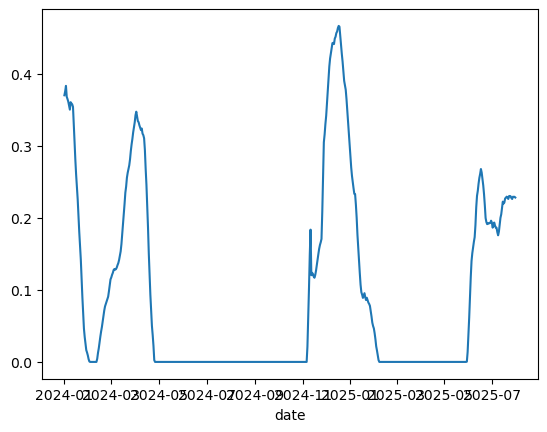

In [189]:
df_os_vov['BTC-USD_final_signal'].plot()

In [183]:
df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
    start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
df_os = df_os[df_os.index >= pd.Timestamp(start_date_os).date()]

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


<Axes: xlabel='date'>

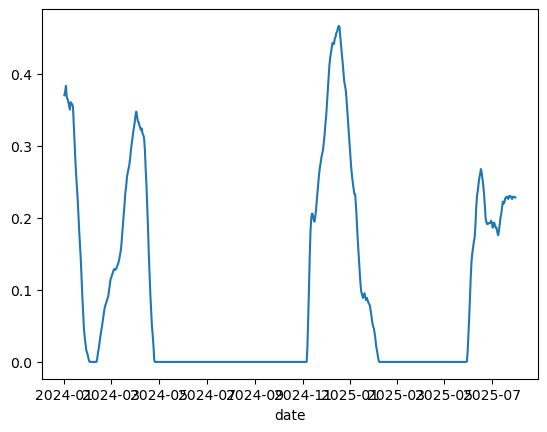

In [187]:
df_os['BTC-USD_final_signal'].plot()

## Walk Forward Analysis for Vol of Vol Signal

In [192]:
import itertools

def generate_vol_of_vol_signal_params():
    parameter_grid = {
        "log_std_window": [10, 14, 20],
        "coef_of_variation_window": [20, 30, 50],
        "vol_of_vol_z_score_window": [126, 180, 252],
        "vol_of_vol_p_min": [0.5, 0.6, 0.7],
        "r2_strong_threshold": [0.75, 0.80, 0.85]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [202]:
def run_walk_forward_vol_of_vol_signal(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'log_std_window', 'coef_of_variation_window', 'vol_of_vol_z_score_window', 'vol_of_vol_p_min', 'r2_strong_threshold', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_vol_of_vol_signal_params():
            print(params)
            log_std_window = params['log_std_window']
            coef_of_variation_window = params['coef_of_variation_window']
            vol_of_vol_z_score_window = params['vol_of_vol_z_score_window']
            vol_of_vol_p_min = params['vol_of_vol_p_min']
            r2_strong_threshold = params['r2_strong_threshold']
            
            print(log_std_window, coef_of_variation_window, vol_of_vol_z_score_window, vol_of_vol_p_min, r2_strong_threshold)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)

            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'log_std_window': log_std_window,
                'coef_of_variation_window': coef_of_variation_window,
                'vol_of_vol_z_score_window': vol_of_vol_z_score_window,
                'vol_of_vol_p_min': vol_of_vol_p_min,
                'r2_strong_threshold': r2_strong_threshold
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        walk_forward_run_cond = in_sample_cond & date_cond

        ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        best_log_std_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['log_std_window'].iloc[0]
        best_coef_of_variation_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['coef_of_variation_window'].iloc[0]
        best_vol_of_vol_z_score_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['vol_of_vol_z_score_window'].iloc[0]
        best_vol_of_vol_p_min = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['vol_of_vol_p_min'].iloc[0]
        best_r2_strong_threshold = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['r2_strong_threshold'].iloc[0]
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=best_log_std_window, coef_of_variation_window=best_coef_of_variation_window, vol_of_vol_z_score_window=best_vol_of_vol_z_score_window, vol_of_vol_p_min=best_vol_of_vol_p_min, r2_strong_threshold=best_r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
        
        ## Out of Sample Performance Metrics
        print('Pulling Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'log_std_window': best_log_std_window,
            'coef_of_variation_window': best_coef_of_variation_window,
            'vol_of_vol_z_score_window': best_vol_of_vol_z_score_window,
            'vol_of_vol_p_min': best_vol_of_vol_p_min,
            'r2_strong_threshold': best_r2_strong_threshold
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [204]:
%%time
df_performance_vol_of_vol_1 = run_walk_forward_vol_of_vol_signal(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.75}
10 20 126 0.5 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.8}
10 20 126 

In [212]:
df_performance_vol_of_vol_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Performance-2022-04-01-2024-04-01.pickle')

In [214]:
%%time
df_performance_vol_of_vol_2 = run_walk_forward_vol_of_vol_signal(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.75}
10 20 126 0.5 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.8}
10 20 126 

In [215]:
df_performance_vol_of_vol_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Performance-2022-10-01-2024-10-01.pickle')

In [216]:
%%time
df_performance_vol_of_vol_3 = run_walk_forward_vol_of_vol_signal(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.75}
10 20 126 0.5 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.8}
10 20 126 

In [217]:
df_performance_vol_of_vol_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Performance-2023-04-01-2025-04-01.pickle')

In [218]:
%%time
df_performance_vol_of_vol_4 = run_walk_forward_vol_of_vol_signal(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.75}
10 20 126 0.5 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 10, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_

In [219]:
df_performance_vol_of_vol_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Performance-2023-10-01-2025-10-01.pickle')

In [220]:
df_performance_vol_of_vol = pd.concat([df_performance_vol_of_vol_1,df_performance_vol_of_vol_2,
                                       df_performance_vol_of_vol_3,df_performance_vol_of_vol_4], axis=0, ignore_index=True)

In [221]:
in_sample_cond = (df_performance_vol_of_vol.sampling_category == 'in_sample')
df_performance_vol_of_vol_is = df_performance_vol_of_vol[in_sample_cond].reset_index(drop=True)
df_performance_vol_of_vol_os = df_performance_vol_of_vol[~in_sample_cond].reset_index(drop=True)

In [222]:
df_performance_vol_of_vol.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Performance-2022-04-01-2025-10-01.pickle')

In [223]:
df_performance_vol_of_vol_is.groupby(['log_std_window','coef_of_variation_window','vol_of_vol_z_score_window','vol_of_vol_p_min','r2_strong_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                        median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                           
14             20                       126                       0.5              0.75                               1.300340   
20             20                       126                       0.6              0.75                               1.291958   
                                                                  0.5              0.75                               1.282372   
14             20                       126                       0.5              0.80                               1.289068   
                                                                                   0.85                               1.288654   
20             20                       180                       0.5              0.75                               1.292534   
                                        126                       0.6              0.85                               1.281316   
                                                                                   0.80                               1.280459   
                                        180                       0.5              0.85                               1.289712   
                                                                  0.6              0.75                               1.295535   
                                                                  0.5              0.80                               1.288597   
                                        126                       0.5              0.85                               1.269413   
14             20                       126                       0.6              0.75                               1.288453   
20             20                       180                       0.6              0.85                               1.293875   
                                        126                       0.5              0.80                               1.268103   
10             20                       126                       0.5              0.75                               1.276110   
20             20                       180                       0.6              0.80                               1.292120   
                                        126                       0.7              0.75                               1.287502   
14             20                       126                       0.6              0.85                               1.280367   
20             20                       126                       0.7              0.85                               1.279423   
14             20                       126                       0.6              0.80                               1.280182   
                                        180                       0.5              0.75                               1.281640   
20             20                       180                       0.7              0.75                               1.288257   
                                        126                       0.7              0.80                               1.278121   
                                        180                       0.7              0.85                               1.286919   
               30                       180                       0.6              0.85                               1.273089   
               20                       180                       0.7              0.80                               1.285830   
14             30                       180                       0.6              0.85                               1.270132   
                                                                         

In [224]:
df_performance_vol_of_vol_os.groupby(['log_std_window','coef_of_variation_window','vol_of_vol_z_score_window','vol_of_vol_p_min','r2_strong_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                        median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                           
20             20                       126                       0.5              0.75                               0.852552   
14             20                       126                       0.5              0.75                               0.840137   
20             20                       180                       0.5              0.75                               0.058452   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 0.852552   
14             20                       126                       0.5              0.75                 0.840137   
20             20                       180                       0.5              0.75                 0.058452   

                                                                                                                  \
                                                                                                             std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 2.222489   
14             20                       126                       0.5              0.75                      NaN   
20             20                       180                       0.5              0.75                      NaN   

                                                                                                       annualized_return  \
                                                                                                                  median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                     
20             20                       126                       0.5              0.75                         0.603136   
14             20                       126                       0.5              0.75                         0.168011   
20             20                       180                       0.5              0.75                         0.033491   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 0.603136   
14             20                       126                       0.5              0.75                 0.168011   
20             20                       180                       0.5              0.75                 0.033491   

                                                                                                                 \
                                                                                                            std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold            
20             20                       126                       0.5              0.75                 0.93275   
14             20         

In [236]:
df_performance_vol_of_vol_os

sampling_category  start_date    end_date  log_std_window  \
0        out_sample  2023-10-01  2024-03-31              20   
1        out_sample  2024-04-01  2024-09-30              20   
2        out_sample  2024-10-01  2025-03-31              20   
3        out_sample  2025-04-01  2025-07-31              14   

   coef_of_variation_window  vol_of_vol_z_score_window  vol_of_vol_p_min  \
0                        20                        126               0.5   
1                        20                        126               0.5   
2                        20                        180               0.5   
3                        20                        126               0.5   

   r2_strong_threshold  annualized_return  annualized_sharpe_ratio  \
0                 0.75           1.262690                 2.424089   
1                 0.75          -0.056418                -0.718985   
2                 0.75           0.033491                 0.058452   
3                 0.75           0.168011                 0.840137   

   calmar_ratio  annualized_std_dev  max_drawdown max_drawdown_duration  \
0      7.006734            0.559227     -0.180211              323 days   
1     -0.375851            0.579076     -0.150107              309 days   
2      0.168420            0.486121     -0.198855              307 days   
3      1.716843            0.310446     -0.097861              341 days   

   hit_rate  t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0  0.193814     2.959411  0.003233        508.0                   0.115827   
1  0.032990    -0.414532  0.678668         42.0                  -0.034964   
2  0.132231     0.295256  0.767926        369.0                   0.131898   
3  0.117925     1.286522  0.198965        227.0                   0.068786   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.227383                   0.101608   
1                  -0.020914                  -0.005965   
2                  -0.012351                  -0.020166   
3                   0.099021                   0.034098   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                   0.172821                    0.404875   
1                   0.004773                    0.035774   
2                  -0.023689                    0.032628   
3                   0.000000                   -0.000083   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                         0.592836                         1.305698   
1                        -0.983554                        -2.109954   
2                         0.639135                        -1.478484   
3                         0.250465                         0.691089   

   SOL-USD_annualized_sharpe_ratio  ADA-USD_annualized_sharpe_ratio  \
0                         0.650467                         1.419840   
1                        -9.438721                        -4.627720   
2                        -1.353530                        -1.071552   
3                        -0.272970                             -inf   

   AVAX-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_dev  \
0                          1.874021                    0.209252   
1                         -0.163923                    0.376153   
2                         -0.177964                    0.269915   
3                         -9.297591                    0.194997   

   ETH-USD_annualized_std_dev  SOL-USD_annualized_std_dev  \
0                    0.224314                    0.140338   
1                    0.183830                    0.039503   
2                    0.097889                    0.115488   
3                    0.159998                    0.116710   

   ADA-USD_annualized_std_dev  AVAX-USD_annualized_std_dev  \
0                1.377997e-01                     0.299712   
1                1.009731e-01                     0.559074   
2                1.289408e-01                     

## Walk Forward Analysis for Vol of Vol Micro Grid

In [294]:
import itertools

def generate_vol_of_vol_signal_params():
    parameter_grid = {
        "log_std_window": [14, 20],
        "coef_of_variation_window": [20, 30],
        "vol_of_vol_z_score_window": [126, 180],
        "vol_of_vol_p_min": [0.3, 0.4, 0.5, 0.6],
        "r2_strong_threshold": [0.65, 0.75, 0.80]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [298]:
def run_walk_forward_vol_of_vol_signal_micro_grid(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'log_std_window', 'coef_of_variation_window', 'vol_of_vol_z_score_window', 'vol_of_vol_p_min', 'r2_strong_threshold', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_vol_of_vol_signal_params():
            print(params)
            log_std_window = params['log_std_window']
            coef_of_variation_window = params['coef_of_variation_window']
            vol_of_vol_z_score_window = params['vol_of_vol_z_score_window']
            vol_of_vol_p_min = params['vol_of_vol_p_min']
            r2_strong_threshold = params['r2_strong_threshold']
            
            print(log_std_window, coef_of_variation_window, vol_of_vol_z_score_window, vol_of_vol_p_min, r2_strong_threshold)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_is)

            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'log_std_window': log_std_window,
                'coef_of_variation_window': coef_of_variation_window,
                'vol_of_vol_z_score_window': vol_of_vol_z_score_window,
                'vol_of_vol_p_min': vol_of_vol_p_min,
                'r2_strong_threshold': r2_strong_threshold
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # walk_forward_run_cond = in_sample_cond & date_cond

        # ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        # best_log_std_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['log_std_window'].iloc[0]
        # best_coef_of_variation_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['coef_of_variation_window'].iloc[0]
        # best_vol_of_vol_z_score_window = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['vol_of_vol_z_score_window'].iloc[0]
        # best_vol_of_vol_p_min = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['vol_of_vol_p_min'].iloc[0]
        # best_r2_strong_threshold = df_performance[walk_forward_run_cond].sort_values('annualized_sharpe_ratio', ascending=False)['r2_strong_threshold'].iloc[0]
        
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
                    start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
                    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date_os)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'log_std_window': log_std_window,
                'coef_of_variation_window': coef_of_variation_window,
                'vol_of_vol_z_score_window': vol_of_vol_z_score_window,
                'vol_of_vol_p_min': vol_of_vol_p_min,
                'r2_strong_threshold': r2_strong_threshold
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [300]:
%%time
df_performance_vol_of_vol_micro_grid_1 = run_walk_forward_vol_of_vol_signal_micro_grid(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.3, 'r2_strong_threshold': 0.65}
14 20 126 0.3 0.65
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop

In [306]:
df_performance_vol_of_vol_micro_grid_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2022-04-01-2024-04-01.pickle')

In [308]:
%%time
df_performance_vol_of_vol_micro_grid_2 = run_walk_forward_vol_of_vol_signal_micro_grid(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.3, 'r2_strong_threshold': 0.65}
14 20 126 0.3 0.65
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop

In [310]:
df_performance_vol_of_vol_micro_grid_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2022-10-01-2024-10-01.pickle')

In [312]:
df_performance_vol_of_vol_micro_grid_2

sampling_category  start_date    end_date  log_std_window  \
0           in_sample  2022-10-01  2024-03-31              14   
1          out_sample  2024-04-01  2024-09-30              14   
2           in_sample  2022-10-01  2024-03-31              14   
3          out_sample  2024-04-01  2024-09-30              14   
4           in_sample  2022-10-01  2024-03-31              14   
5          out_sample  2024-04-01  2024-09-30              14   
6           in_sample  2022-10-01  2024-03-31              14   
7          out_sample  2024-04-01  2024-09-30              14   
8           in_sample  2022-10-01  2024-03-31              14   
9          out_sample  2024-04-01  2024-09-30              14   
10          in_sample  2022-10-01  2024-03-31              14   
11         out_sample  2024-04-01  2024-09-30              14   
12          in_sample  2022-10-01  2024-03-31              14   
13         out_sample  2024-04-01  2024-09-30              14   
14          in_sample  2022-10-01  2024-03-31              14   
15         out_sample  2024-04-01  2024-09-30              14   
16          in_sample  2022-10-01  2024-03-31              14   
17         out_sample  2024-04-01  2024-09-30              14   
18          in_sample  2022-10-01  2024-03-31              14   
19         out_sample  2024-04-01  2024-09-30              14   
20          in_sample  2022-10-01  2024-03-31              14   
21         out_sample  2024-04-01  2024-09-30              14   
22          in_sample  2022-10-01  2024-03-31              14   
23         out_sample  2024-04-01  2024-09-30              14   
24          in_sample  2022-10-01  2024-03-31              14   
25         out_sample  2024-04-01  2024-09-30              14   
26          in_sample  2022-10-01  2024-03-31              14   
27         out_sample  2024-04-01  2024-09-30              14   
28          in_sample  2022-10-01  2024-03-31              14   
29         out_sample  2024-04-01  2024-09-30              14   
30          in_sample  2022-10-01  2024-03-31              14   
31         out_sample  2024-04-01  2024-09-30              14   
32          in_sample  2022-10-01  2024-03-31              14   
33         out_sample  2024-04-01  2024-09-30              14   
34          in_sample  2022-10-01  2024-03-31              14   
35         out_sample  2024-04-01  2024-09-30              14   
36          in_sample  2022-10-01  2024-03-31              14   
37         out_sample  2024-04-01  2024-09-30              14   
38          in_sample  2022-10-01  2024-03-31              14   
39         out_sample  2024-04-01  2024-09-30              14   
40          in_sample  2022-10-01  2024-03-31              14   
41         out_sample  2024-04-01  2024-09-30              14   
42          in_sample  2022-10-01  2024-03-31              14   
43         out_sample  2024-04-01  2024-09-30              14   
44          in_sample  2022-10-01  2024-03-31              14   
45         out_sample  2024-04-01  2024-09-30              14   
46          in_sample  2022-10-01  2024-03-31              14   
47         out_sample  2024-04-01  2024-09-30              14   
48          in_sample  2022-10-01  2024-03-31              14   
49         out_sample  2024-04-01  2024-09-30              14   
50          in_sample  2022-10-01  2024-03-31              14   
51         out_sample  2024-04-01  2024-09-30              14   
52          in_sample  2022-10-01  2024-03-31              14   
53         out_sample  2024-04-01  2024-09-30              14   
54          in_sample  2022-10-01  2024-03-31              14   
55         out_sample  2024-04-01  2024-09-30              14   
56          in_sample  2022-10-01  2024-03-31              14   
57         out_sample  2024-04-01  2024-09-30              14   
58          in_sample  2022-10-01  2024-03-31              14   
59         out_sample  2024-04-01  2024-09-30              14   
60          in_sample  2022-10-01  2024

In [247]:
%%time
df_performance_vol_of_vol_micro_grid_3 = run_walk_forward_vol_of_vol_signal_micro_grid(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.75}
14 20 126 0.4 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.8}
14 20 126 

In [248]:
df_performance_vol_of_vol_micro_grid_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2023-04-01-2025-04-01.pickle')

In [249]:
%%time
df_performance_vol_of_vol_micro_grid_4 = run_walk_forward_vol_of_vol_signal_micro_grid(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.75}
14 20 126 0.4 0.75
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_

In [250]:
df_performance_vol_of_vol_micro_grid_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2023-10-01-2025-10-01.pickle')

In [251]:
df_performance_vol_of_vol_micro_grid = pd.concat([df_performance_vol_of_vol_micro_grid_1, df_performance_vol_of_vol_micro_grid_2,
                                                  df_performance_vol_of_vol_micro_grid_3, df_performance_vol_of_vol_micro_grid_4], axis=0, ignore_index=True)

In [252]:
df_performance_vol_of_vol_micro_grid.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2022-04-01-2025-10-01.pickle')

In [253]:
df_performance_vol_of_vol_micro_grid = pd.read_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Vol_of_Vol_Signal_Micro_Grid_Performance-2022-04-01-2025-10-01.pickle')

In [254]:
in_sample_cond = (df_performance_vol_of_vol_micro_grid.sampling_category == 'in_sample')
df_performance_vol_of_vol_micro_grid_is = df_performance_vol_of_vol_micro_grid[in_sample_cond].reset_index(drop=True)
df_performance_vol_of_vol_micro_grid_os = df_performance_vol_of_vol_micro_grid[~in_sample_cond].reset_index(drop=True)

In [276]:
df_performance_vol_of_vol_micro_grid_is.groupby(['log_std_window','coef_of_variation_window','vol_of_vol_z_score_window','vol_of_vol_p_min','r2_strong_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                        median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                           
14             20                       126                       0.4              0.75                               1.302585   
                                                                  0.5              0.75                               1.300340   
                                                                  0.4              0.80                               1.288578   
20             20                       126                       0.4              0.75                               1.279392   
                                                                  0.6              0.75                               1.291958   
                                                                  0.5              0.75                               1.282372   
14             20                       126                       0.5              0.80                               1.289068   
20             20                       180                       0.5              0.75                               1.292534   
                                                                  0.4              0.75                               1.291060   
                                        126                       0.6              0.80                               1.280459   
                                        180                       0.6              0.75                               1.295535   
                                                                  0.5              0.80                               1.288597   
                                                                  0.4              0.80                               1.285692   
14             20                       126                       0.6              0.75                               1.288453   
20             20                       126                       0.5              0.80                               1.268103   
                                        180                       0.6              0.80                               1.292120   
                                        126                       0.4              0.80                               1.260139   
14             20                       180                       0.4              0.75                               1.279177   
                                        126                       0.6              0.80                               1.280182   
                                        180                       0.5              0.75                               1.281640   
               30                       180                       0.6              0.75                               1.270016   
20             30                       180                       0.6              0.75                               1.270383   
14             30                       180                       0.4              0.75                               1.252636   
20             30                       180                       0.6              0.80                               1.270806   
14             30                       180                       0.6              0.80                               1.266765   
               20                       180                       0.6              0.75                               1.277530   
               30                       180                       0.4              0.80                               1.249648   
                                                                  0.5              0.75                               1.256328   
20             30                       180                       0.5    

In [257]:
df_performance_vol_of_vol_micro_grid_os.groupby(['log_std_window','coef_of_variation_window','vol_of_vol_z_score_window','vol_of_vol_p_min','r2_strong_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                        median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                           
14             20                       126                       0.4              0.75                               0.842667   
20             20                       180                       0.5              0.75                               0.058452   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
14             20                       126                       0.4              0.75                 0.840320   
20             20                       180                       0.5              0.75                 0.058452   

                                                                                                                  \
                                                                                                             std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
14             20                       126                       0.4              0.75                 1.587143   
20             20                       180                       0.5              0.75                      NaN   

                                                                                                       annualized_return  \
                                                                                                                  median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                     
14             20                       126                       0.4              0.75                         0.168489   
20             20                       180                       0.5              0.75                         0.033491   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
14             20                       126                       0.4              0.75                 0.462013   
20             20                       180                       0.5              0.75                 0.033491   

                                                                                                                  \
                                                                                                             std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
14             20                       126                       0.4              0.75                 0.714807   
20             20                       180                       0.5              0.75                      NaN   

                                                                                                       max_drawdown  \
                                                                                                             median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                
14             20                       126                       0.4              0.75                   -0.148809   
20             20              

In [274]:
df_performance_vol_of_vol_os.groupby(['log_std_window','coef_of_variation_window','vol_of_vol_z_score_window','vol_of_vol_p_min','r2_strong_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                        median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                           
20             20                       126                       0.5              0.75                               0.852552   
14             20                       126                       0.5              0.75                               0.840137   
20             20                       180                       0.5              0.75                               0.058452   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 0.852552   
14             20                       126                       0.5              0.75                 0.840137   
20             20                       180                       0.5              0.75                 0.058452   

                                                                                                                  \
                                                                                                             std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 2.222489   
14             20                       126                       0.5              0.75                      NaN   
20             20                       180                       0.5              0.75                      NaN   

                                                                                                       annualized_return  \
                                                                                                                  median   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold                     
20             20                       126                       0.5              0.75                         0.603136   
14             20                       126                       0.5              0.75                         0.168011   
20             20                       180                       0.5              0.75                         0.033491   

                                                                                                                  \
                                                                                                            mean   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold             
20             20                       126                       0.5              0.75                 0.603136   
14             20                       126                       0.5              0.75                 0.168011   
20             20                       180                       0.5              0.75                 0.033491   

                                                                                                                 \
                                                                                                            std   
log_std_window coef_of_variation_window vol_of_vol_z_score_window vol_of_vol_p_min r2_strong_threshold            
20             20                       126                       0.5              0.75                 0.93275   
14             20         

In [292]:
for params in generate_vol_of_vol_signal_params():
    print(params)

{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.75}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.8}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.75}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.5, 'r2_strong_threshold': 0.8}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.6, 'r2_strong_threshold': 0.75}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 126, 'vol_of_vol_p_min': 0.6, 'r2_strong_threshold': 0.8}
{'log_std_window': 14, 'coef_of_variation_window': 20, 'vol_of_vol_z_score_window': 180, 'vol_of_vol_p_min': 0.4, 'r2_strong_threshold': 0.75}
{'

In [278]:
df_performance_vol_of_vol_micro_grid_os

sampling_category  start_date    end_date  log_std_window  \
0        out_sample  2023-10-01  2024-03-31              14   
1        out_sample  2024-04-01  2024-09-30              14   
2        out_sample  2024-10-01  2025-03-31              20   
3        out_sample  2025-04-01  2025-07-31              14   

   coef_of_variation_window  vol_of_vol_z_score_window  vol_of_vol_p_min  \
0                        20                        126               0.4   
1                        20                        126               0.4   
2                        20                        180               0.5   
3                        20                        126               0.4   

   r2_strong_threshold  annualized_return  annualized_sharpe_ratio  \
0                 0.75           1.276855                 2.426288   
1                 0.75          -0.059306                -0.747995   
2                 0.75           0.033491                 0.058452   
3                 0.75           0.168489                 0.842667   

   calmar_ratio  annualized_std_dev  max_drawdown max_drawdown_duration  \
0      6.789371            0.563553     -0.188067              323 days   
1     -0.398537            0.565419     -0.148809              309 days   
2      0.168420            0.486121     -0.198855              307 days   
3      1.721726            0.310641     -0.097861              341 days   

   hit_rate  t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0  0.195876     2.960681  0.003220        499.0                   0.114496   
1  0.032990    -0.444924  0.656574         42.0                  -0.033740   
2  0.132231     0.295256  0.767926        369.0                   0.131898   
3  0.117925     1.289017  0.198097        229.0                   0.068788   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.231233                   0.100688   
1                  -0.024803                  -0.005932   
2                  -0.012351                  -0.020166   
3                   0.099071                   0.034219   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                   0.182556                    0.399303   
1                   0.004773                    0.035774   
2                  -0.023689                    0.032628   
3                   0.000000                   -0.000098   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                         0.577947                         1.322716   
1                        -0.937904                        -2.642872   
2                         0.639135                        -1.478484   
3                         0.250480                         0.692699   

   SOL-USD_annualized_sharpe_ratio  ADA-USD_annualized_sharpe_ratio  \
0                         0.621849                         1.505078   
1                        -9.470183                        -4.627720   
2                        -1.353530                        -1.071552   
3                        -0.265338                             -inf   

   AVAX-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_dev  \
0                          1.825053                    0.211216   
1                         -0.163923                    0.387514   
2                         -0.177964                    0.269915   
3                        -11.304564                    0.194997   

   ETH-USD_annualized_std_dev  SOL-USD_annualized_std_dev  \
0                    0.225766                    0.145036   
1                    0.152911                    0.039358   
2                    0.097889                    0.115488   
3                    0.159746                    0.118700   

   ADA-USD_annualized_std_dev  AVAX-USD_annualized_std_dev  \
0                1.394074e-01                     0.304315   
1                1.009731e-01                     0.559074   
2                1.289408e-01                     

<Axes: xlabel='date'>

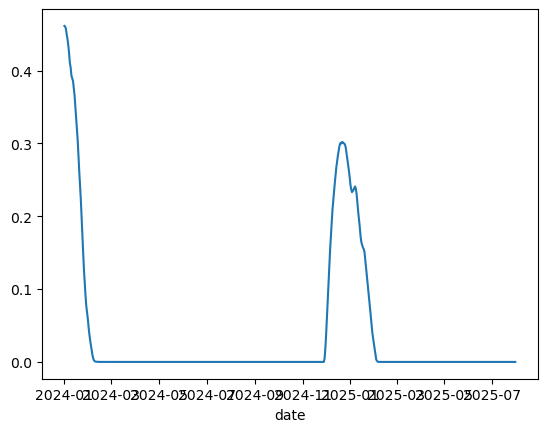

In [284]:
df_os['ADA-USD_final_signal'].plot()

<Axes: xlabel='date'>

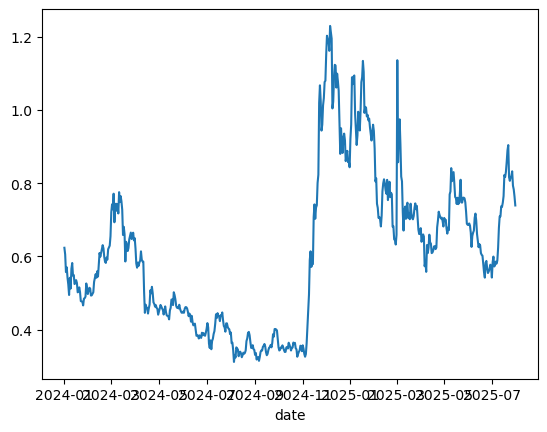

In [286]:
df_os['ADA-USD_close'].plot()

In [416]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                      slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                      exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                      donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                      rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                      long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [484]:
print(start_date_os)
print(start_date_os - pd.Timedelta(days=283))

2024-01-01
2023-03-24


In [514]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
WARMUP_DAYS = 534
df_trend_vov = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                                     slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                                     exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                                     donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                                     rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                                     log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                                                     vol_of_vol_p_min=vol_of_vol_p_min,
                                                                                     long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [516]:
for ticker in ticker_list:
    df_trend_vov[f'{ticker}_t_1_close'] = df_trend_vov[f'{ticker}_close'].shift(1)

In [518]:
df_trend_vov.head()

BTC-USD_close  BTC-USD_open  BTC-USD_mavg_ribbon_slope  \
date                                                                 
2022-07-16       21189.68      20823.06                        NaN   
2022-07-17       20791.74      21189.23               4.594532e-15   
2022-07-18       22427.56      20791.74              -7.407949e-04   
2022-07-19       23395.06      22434.97               1.561179e-03   
2022-07-20       23226.99      23398.46               5.254617e-03   

            BTC-USD_mavg_ribbon_rank  BTC-USD_final_weighted_additive_signal  \
date                                                                           
2022-07-16                       NaN                                     NaN   
2022-07-17                       NaN                                     NaN   
2022-07-18                       NaN                                     NaN   
2022-07-19                       NaN                                     NaN   
2022-07-20                       NaN                                     NaN   

            BTC-USD_rolling_r_sqr  BTC-USD_vol_of_vol_penalty  \
date                                                            
2022-07-16                    0.0                         1.0   
2022-07-17                    0.0                         1.0   
2022-07-18                    0.0                         1.0   
2022-07-19                    0.0                         1.0   
2022-07-20                    0.0                         1.0   

            BTC-USD_regime_filter  BTC-USD_final_signal  ETH-USD_close  \
date                                                                     
2022-07-16                    0.0                   NaN        1355.70   
2022-07-17                    0.0                   NaN        1338.20   
2022-07-18                    0.0                   NaN        1581.34   
2022-07-19                    0.0                   NaN        1542.63   
2022-07-20                    0.0                   NaN        1522.12   

            ETH-USD_open  ETH-USD_mavg_ribbon_slope  ETH-USD_mavg_ribbon_rank  \
date                                                                            
2022-07-16       1231.07                        NaN                       NaN   
2022-07-17       1355.50               3.308833e-15                       NaN   
2022-07-18       1338.03              -5.076767e-04                       NaN   
2022-07-19       1581.09               5.565238e-03                       NaN   
2022-07-20       1542.60               9.985883e-03                       NaN   

            ETH-USD_final_weighted_additive_signal  ETH-USD_rolling_r_sqr  \
date                                                                        
2022-07-16                                     NaN                    0.0   
2022-07-17                                     NaN                    0.0   
2022-07-18                                     NaN                    0.0   
2022-07-19                                     NaN                    0.0   
2022-07-20                                     NaN                    0.0   

            ETH-USD_vol_of_vol_penalty  ETH-USD_regime_filter  \
date                                                            
2022-07-16                         1.0                    0.0   
2022-07-17                         1.0                    0.0   
2022-07-18                         1.0                    0.0   
2022-07-19                         1.0                    0.0   
2022-07-20                         1.0                    0.0   

            ETH-USD_final_signal  SOL-USD_close  SOL-USD_open  \
date                                                            
2022-07-16                   NaN          39.60         37.36   
2022-07-17                   NaN          38.63         39.57   
2022-07-18                   NaN          43.55         38.59   
2022-07-19                   NaN          44.88         43.56   
2022-07-20                   Na

In [520]:
df_trend_vov_check = generate_vol_of_vol_signal_log_space(df_trend_vov, ticker='AVAX-USD', t_1_close_price_col='AVAX-USD_t_1_close')

<Axes: xlabel='date'>

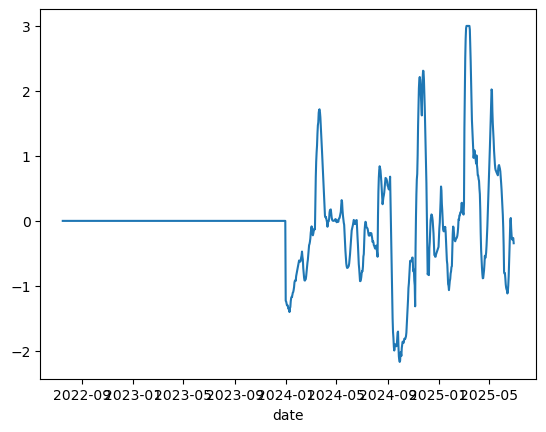

In [522]:
df_trend_vov['AVAX-USD_vol_of_vol_robust_z_score'].plot()

In [526]:
cols = [col for col in df_trend_vov_check.columns if 'AVAX-USD' in col]
df_trend_vov_check[cols]

AVAX-USD_close  AVAX-USD_open  AVAX-USD_mavg_ribbon_slope  \
date                                                                    
2022-07-16           21.24          19.36                         NaN   
2022-07-17           20.62          21.24                1.666389e-15   
2022-07-18           23.97          20.62               -1.157574e-03   
2022-07-19           24.73          23.97                3.697623e-03   
2022-07-20           23.59          24.71                9.226307e-03   
2022-07-21           24.98          23.58                1.228539e-02   
2022-07-22           23.63          24.99                1.723023e-02   
2022-07-23           23.60          23.64                1.943783e-02   
2022-07-24           23.80          23.62                2.133395e-02   
2022-07-25           20.91          23.79                2.333096e-02   
2022-07-26           20.71          20.92                2.002735e-02   
2022-07-27           23.38          20.73                1.670129e-02   
2022-07-28           24.23          23.40                1.847102e-02   
2022-07-29           24.51          24.26                2.142140e-02   
2022-07-30           24.25          24.52                2.447145e-02   
2022-07-31           23.74          24.25                2.674187e-02   
2022-08-01           23.59          23.70                2.790410e-02   
2022-08-02           22.85          23.60                2.866380e-02   
2022-08-03           23.05          22.86                2.806730e-02   
2022-08-04           23.37          23.04                2.785229e-02   
2022-08-05           24.95          23.37                2.817396e-02   
2022-08-06           26.64          24.95                3.098915e-02   
2022-08-07           27.90          26.65                3.602100e-02   
2022-08-08           27.92          27.90                4.226221e-02   
2022-08-09           27.43          27.91                4.779478e-02   
2022-08-10           29.18          27.41                5.197368e-02   
2022-08-11           28.56          29.17                5.805523e-02   
2022-08-12           29.35          28.57                6.256546e-02   
2022-08-13           29.19          29.35                6.758149e-02   
2022-08-14           28.21          29.19                7.176234e-02   
2022-08-15           27.90          28.20                7.407663e-02   
2022-08-16           27.12          27.88                7.563315e-02   
2022-08-17           25.56          27.10                7.583821e-02   
2022-08-18           24.19          25.57                7.363489e-02   
2022-08-19           22.44          24.20                6.945557e-02   
2022-08-20           22.30          22.45                6.274176e-02   
2022-08-21           22.97          22.31                5.647089e-02   
2022-08-22           22.56          22.98                5.199848e-02   
2022-08-23           23.51          22.56                4.726558e-02   
2022-08-24           23.01          23.52                4.462013e-02   
2022-08-25           22.98          23.00                4.137867e-02   
2022-08-26           20.68          22.99                3.839946e-02   
2022-08-27           20.05          20.67                3.158582e-02   
2022-08-28           18.53          20.05                2.428410e-02   
2022-08-29           19.33          18.52                1.468290e-02   
2022-08-30           19.40          19.33                7.779317e-03   
2022-08-31           19.13          19.40                1.766774e-03   
2022-09-01           19.33          19.14               -4.137987e-03   
2022-09-02           18.87          19.34               -8.987556e-03   
2022-09-03           18.89          18.87               -1.424279e-02   
2022-09-04           19.03          18.89               -1.887061e-02   
2022-09-05           19.44          19.03               -2.268938e-02   
2022-09-06           18.21          19.44               -2.524107e-02 

In [510]:
df_trend_vov[(df_trend_vov.index <= pd.Timestamp('2024-06-22').date())].shape

(534, 57)

In [512]:
534/2

267.0

<Axes: xlabel='date'>

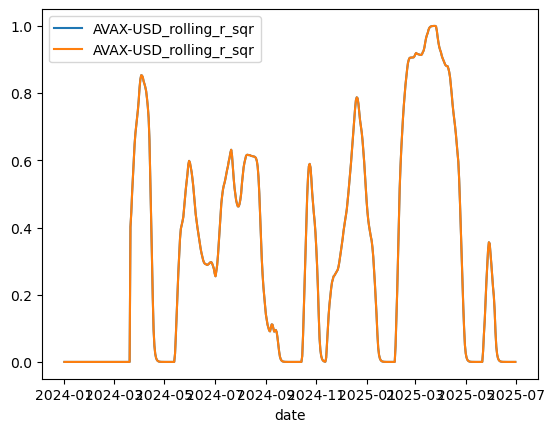

In [420]:
df_trend['AVAX-USD_rolling_r_sqr'].plot()

<Axes: xlabel='date'>

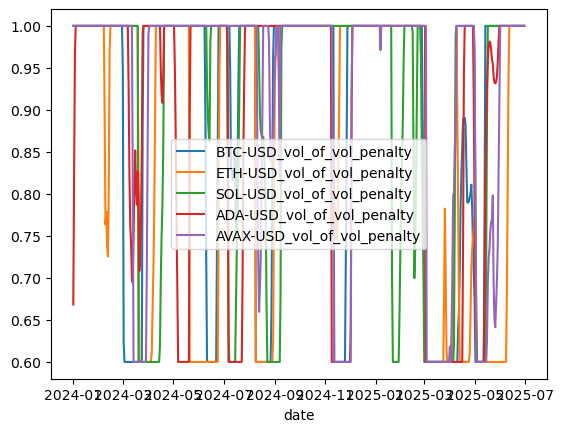

In [528]:
## 534
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

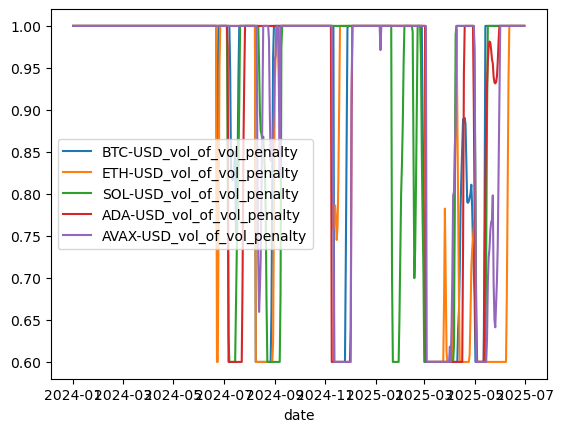

In [502]:
## 360
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

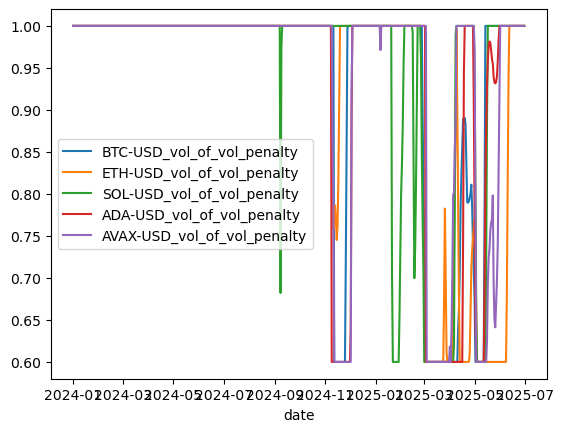

In [488]:
## 283
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

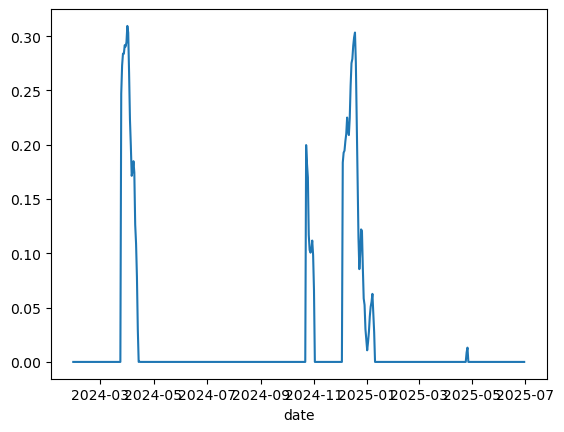

In [392]:
df_os['AVAX-USD_final_signal'].plot()

In [386]:
start_date_os

datetime.date(2024, 1, 1)

In [576]:
perf.calculate_risk_and_performance_metrics(df_os_vov[df_os_vov.index >= pd.Timestamp(start_date_os).date()], strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.02122948238308009,
 'annualized_sharpe_ratio': 0.029174153461011945,
 'calmar_ratio': -0.0494950809484958,
 'annualized_std_dev': 0.4894843478339456,
 'max_drawdown': -0.4289210559160682,
 'max_drawdown_duration': Timedelta('475 days 00:00:00'),
 'hit_rate': 0.2979890310786106,
 't_statistic': 0.1827808998098945,
 'p_value': 0.855037783355945,
 'trade_count': 1042.0}

In [578]:
df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
            start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
            use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [580]:
perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.15594733200722966,
 'annualized_sharpe_ratio': -0.5786746974924701,
 'calmar_ratio': -0.4228520782782886,
 'annualized_std_dev': 0.5498902387847863,
 'max_drawdown': -0.36879878335278554,
 'max_drawdown_duration': Timedelta('455 days 00:00:00'),
 'hit_rate': 0.15399239543726237,
 't_statistic': -0.499259304161487,
 'p_value': 0.6178058646975957,
 'trade_count': 318.0}

In [510]:
df_rolling_r2_locked_params_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31.pickle')

In [524]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'calmar_ratio':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'max_drawdown':['median','mean','std'],}

agg_dict = {'annualized_sharpe_ratio':['median','mean'],
            'annualized_return':['median','mean'],
            # 'calmar_ratio':['median','mean'],
            'annualized_std_dev':['median','mean'],
            'max_drawdown':['median','mean'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean']}
df_rolling_r2_locked_params_performance.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit']).agg(agg_dict)

annualized_sharpe_ratio  \
                                                                       median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                           
50                0.2               0.6                              0.140177   
                                    0.9                              0.051404   
                  0.3               0.6                             -0.142183   
                                    0.9                             -0.235173   
80                0.2               0.6                              0.853225   
                                    0.9                              0.853812   
                  0.3               0.6                              0.704425   
                                    0.9                              0.687912   

                                                                 \
                                                           mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit             
50                0.2               0.6                0.155338   
                                    0.9                0.145652   
                  0.3               0.6                0.106637   
                                    0.9                0.104349   
80                0.2               0.6                0.873205   
                                    0.9                0.865304   
                  0.3               0.6                0.679917   
                                    0.9                0.658588   

                                                      annualized_return  \
                                                                 median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                     
50                0.2               0.6                        0.024744   
                                    0.9                       -0.014146   
                  0.3               0.6                       -0.080547   
                                    0.9                       -0.093296   
80                0.2               0.6                        0.334249   
                                    0.9                        0.331881   
                  0.3               0.6                        0.268579   
                                    0.9                        0.262812   

                                                                 \
                                                           mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit             
50                0.2               0.6                0.228914   
                                    0.9                0.230789   
                  0.3               0.6                0.268728   
                                    0.9                0.279422   
80                0.2               0.6                0.345938   
                                    0.9                0.341528   
                  0.3               0.6                0.256595   
                                    0.9                0.248517   

                                                      annualized_std_dev  \
                                                                  median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                      
50                0.2               0.6                         0.593591   
                                    0.9                         0.602959   
                  0.3               0.6                         0.627126   
                                    0.9                         0.634717   
80                0.2               0.6                         0.600429   
                                    0.9                         0.608485   
                  0.3               0.6                         0.616281   
                                    0.9                         0.620426   

                       

In [522]:
agg_dict = {'annualized_sharpe_ratio':['median','mean'],
            'annualized_return':['median','mean'],
            # 'calmar_ratio':['median','mean'],
            'annualized_std_dev':['median','mean'],
            'max_drawdown':['median','mean'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean']}
df_rolling_r2_locked_params_performance.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','start_date']).agg(agg_dict)

annualized_sharpe_ratio  \
                                                                                  median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit start_date                           
50                0.2               0.6               2023-06-01                1.872357   
                                                      2023-12-01               -0.100270   
                                                      2024-06-01                0.380623   
                                                      2024-12-01               -1.531359   
                                    0.9               2023-06-01                1.932569   
                                                      2023-12-01               -0.212618   
                                                      2024-06-01                0.315427   
                                                      2024-12-01               -1.452771   
                  0.3               0.6               2023-06-01                2.274751   
                                                      2023-12-01               -0.573259   
                                                      2024-06-01                0.288892   
                                                      2024-12-01               -1.563838   
                                    0.9               2023-06-01                2.336882   
                                                      2023-12-01               -0.710277   
                                                      2024-06-01                0.239931   
                                                      2024-12-01               -1.449138   
80                0.2               0.6               2023-06-01                1.475890   
                                                      2023-12-01                0.310482   
                                                      2024-06-01                0.891134   
                                                      2024-12-01                0.815315   
                                    0.9               2023-06-01                1.478576   
                                                      2023-12-01                0.275015   
                                                      2024-06-01                0.828826   
                                                      2024-12-01                0.878797   
                  0.3               0.6               2023-06-01                1.120458   
                                                      2023-12-01                0.190359   
                                                      2024-06-01                0.468764   
                                                      2024-12-01                0.940086   
                                    0.9               2023-06-01                1.123806   
                                                      2023-12-01                0.134723   
                                                      2024-06-01                0.380944   
                                                      2024-12-01                0.994880   

                                                                            \
                                                                      mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit start_date             
50                0.2               0.6               2023-06-01  1.872357   
                                                      2023-12-01 -0.100270   
                                                      2024-06-01  0.380623   
                                                      2024-12-01 -1.531359   
                                    0.9               2023-06-01  1.932569   
                                                      2023-12-01 -0.212618   
                                                      2024-06-01  0.315427   
                                                      2024-12-01

In [171]:
## With activation
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


<Axes: xlabel='date'>

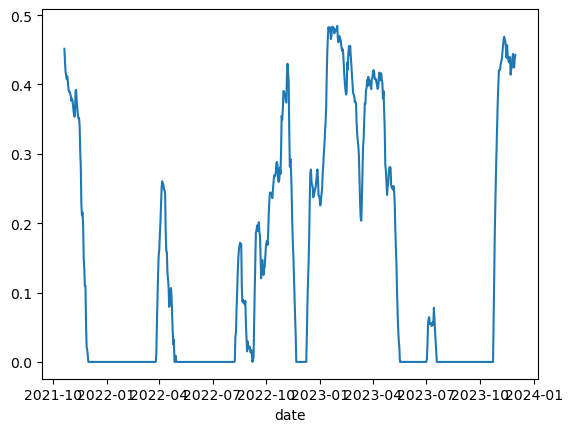

In [163]:
## Without Activation
df_is['BTC-USD_final_signal'].plot()

<Axes: xlabel='date'>

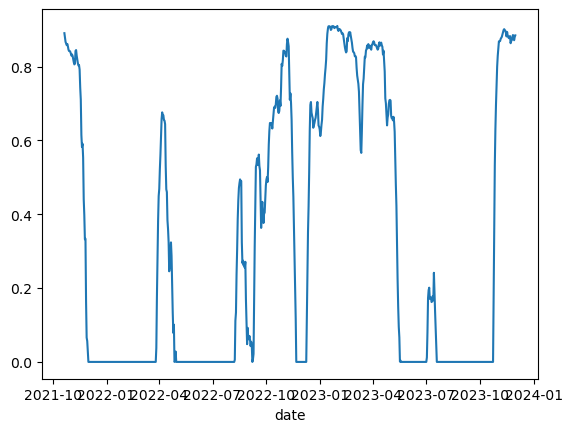

In [172]:
## With Activation
df_is['BTC-USD_final_signal'].plot()

In [155]:
df_is.head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2021-10-21                      3029.172671                          0.000000   
2021-10-22                      3178.856226                       4543.743741   
2021-10-23                      3233.250872                       4432.631533   
2021-10-24                      3125.322217                       4477.711038   
2021-10-25                      3015.202958                       4444.686287   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2021-10-21                      0.000000                          0.654385   
2021-10-22                      0.073046                          0.639165   
2021-10-23                      0.073046                          0.651724   
2021-10-24                      0.073046                          0.651816   
2021-10-25                      0.073046                          0.656002   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2021-10-21                         0.0       62204.02   
2021-10-22                         0.0       60687.64   
2021-10-23                         0.0       61300.01   
2021-10-24                         0.0       60854.48   
2021-10-25                         0.0       63083.54   

            BTC-USD_cooldown_counter       BTC-USD_event  \
date                                                       
2021-10-21                       0.0                 NaN   
2021-10-22                       0.0   New Long Position   
2021-10-23                       0.0  Open Long Position   
2021-10-24                       0.0  Open Long Position   
2021-10-25                       0.0  Open Long Position   

            BTC-USD_final_signal  BTC-USD_final_weighted_additive_signal  \
date                                                                       
2021-10-21              0.451489                                0.451489   
2021-10-22              0.433038                                0.433038   
2021-10-23              0.418481                                0.418481   
2021-10-24              0.413344                                0.413344   
2021-10-25              0.407576                                0.407576   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2021-10-21                                   0.00   
2021-10-22                               62204.01   
2021-10-23                               60682.88   
2021-10-24                               61300.02   
2021-10-25                               60847.91   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2021-10-21                       0.000000                   0.000000   
2021-10-22                    4543.743741                   0.073046   
2021-10-23                       0.000000                   0.000000   
2021-10-24                       0.000000                   0.000000   
2021-10-25                       0.000000                   0.000000   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2021-10-21      66021.26                        0.000000   
2021-10-22      62204.01                        0.000000   
2021-10-23      60682.88                     4432.631533   
2021-10-24      61300.02                     4477.711038   
2021-10-25      60847.91                     4444.686287   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2021-10-21                    0.000000                          0.0   
2021-10-22                    0.

In [157]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23400134562743602,
 'annualized_sharpe_ratio': -0.47510497520815587,
 'calmar_ratio': -0.3280133746315728,
 'annualized_std_dev': 0.5652218255963256,
 'max_drawdown': -0.7133896472674877,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5329376375777404,
 'p_value': 0.5942305209159131,
 'trade_count': 1054.0}

In [132]:
np.abs(df_is['BTC-USD_final_weighted_additive_signal']).quantile(0.95)

0.46594857579383253

In [108]:
np.abs(df_is['ETH-USD_final_weighted_additive_signal']).quantile(0.95)

0.4699992899434025

In [110]:
np.abs(df_is['ADA-USD_final_weighted_additive_signal']).quantile(0.95)

0.4706896393150276

In [112]:
np.abs(df_is['SOL-USD_final_weighted_additive_signal']).quantile(0.95)

0.47152392407208465

In [114]:
np.abs(df_is['AVAX-USD_final_weighted_additive_signal']).quantile(0.95)

0.47236458399095443

In [248]:
final_weighted_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
tanh_activation_constant_dict = {}
for ticker in ticker_list:
    tanh_activation_constant_dict[ticker] = np.abs(df_is[f'{ticker}_final_weighted_additive_signal']).quantile(0.95)

In [250]:
tanh_activation_constant_dict

{'BTC-USD': 0.46594857579383253,
 'ETH-USD': 0.4699992899434025,
 'SOL-USD': 0.47152392407208465,
 'ADA-USD': 0.4706896393150276,
 'AVAX-USD': 0.47254282901082484}

In [136]:
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [138]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23399189526878894,
 'annualized_sharpe_ratio': -0.47448346144804493,
 'calmar_ratio': -0.32790121104352055,
 'annualized_std_dev': 0.564685901685028,
 'max_drawdown': -0.7136048522789153,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5321355580181899,
 'p_value': 0.5947856141730341,
 'trade_count': 1060.0}

In [388]:
## Decide on which entry gate to use for the Donchian Channel Signal
## Lock the Stepsize to 8 and gate to False
entry_cond = ((df_performance_os['cluster'] == 'MA_16_224') & (df_performance_os['entry'].isin([21, 28])) & (df_performance_os['gate'] == False) & (df_performance_os['step'].isin([6, 8])))
df_ma_ribbon_weight_performance = (
    df_performance_os[entry_cond]
    .groupby(["cluster","entry","step","mavg_ribbon_weight","donchian_weight"])
    .agg(mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"))
    .reset_index()
    .sort_values("mean_sharpe", ascending=False)
)
## Entry window of 28 has the best performance

In [390]:
df_ma_ribbon_weight_performance

cluster  entry  step  mavg_ribbon_weight  donchian_weight  mean_sharpe  \
2  MA_16_224     28     8                 0.8              0.2     1.599653   
0  MA_16_224     28     6                 0.7              0.3     1.406795   
1  MA_16_224     28     6                 1.0              0.0     0.301437   
3  MA_16_224     28     8                 1.0              0.0     0.288365   

   sharpe_std  worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
2    0.000000      1.599653        1.000000 -0.299902 -0.299902     0.876251   
0    0.000000      1.406795        1.000000 -0.318594 -0.318594     0.739236   
1    0.902938     -0.866479        0.666667 -0.290080 -0.241992     0.240621   
3    0.943051     -0.848256        0.666667 -0.290532 -0.241953     0.246418   

   mean_trade_count  
2        240.000000  
0        253.000000  
1        189.666667  
3        187.333333

In [362]:
# OOS only, fixed structure
filt = (df_performance_os["cluster"].eq("MA_16_224") &
        df_performance_os["entry"].eq(28) &
        df_performance_os["step"].eq(8) &
        df_performance_os["gate"].eq(False) &
        df_performance_os["exit"].isin([21, 28]))      # or include all exits you keep

w_profile = (df_performance_os.loc[filt]
             .groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
             .agg(mean_sharpe="mean", worst="min", count="size")
             .sort_index())

print(w_profile)  # look for a broad top; 0.65–0.70 should stand out


                    mean_sharpe     worst  count
mavg_ribbon_weight                              
0.8                    1.599653  1.599653      2
1.0                    0.288365 -0.848256      6


In [372]:
filt = (df_performance_is["cluster"].eq("MA_16_224") &
        df_performance_is["entry"].eq(28) &
        df_performance_is["step"].eq(8) &
        df_performance_is["gate"].eq(False) &
        df_performance_is["exit"].isin([21, 28])) 

In [380]:
(df_performance_is[filt].groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
 .agg(mean_sharpe="mean", worst="min", count="size")
 .sort_index())

mean_sharpe     worst  count
mavg_ribbon_weight                              
0.0                   -0.336300 -1.790570      8
0.1                   -0.339208 -1.533497      8
0.2                   -0.329561 -1.764056      8
0.3                   -0.357665 -1.570500      8
0.4                   -0.456633 -1.835694      8
0.5                   -0.182735 -1.338456      8
0.6                   -0.090852 -1.242756      8
0.7                    0.042317 -1.171769      8
0.8                    0.132148 -0.994416      8
0.9                    0.195636 -0.803920      8
1.0                    0.263339 -0.969117      8

In [115]:
df_performance.head()

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
0         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
1         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
2         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
3         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
4         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   

   mavg_ribbon_weight  donchian_weight  annualized_return  \
0                 0.0              1.0          -0.620453   
1                 0.1              0.9          -0.562871   
2                 0.2              0.8          -0.609231   
3                 0.3              0.7          -0.573392   
4                 0.4              0.6          -0.582723   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                -1.790570     -0.724938            0.605099     -0.855872   
1                -1.525900     -0.689592            0.601925     -0.816238   
2                -1.811975     -0.726001            0.589945     -0.839160   
3                -1.628057     -0.701307            0.591289     -0.817604   
4                -1.713242     -0.721869            0.577925     -0.807242   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              554 days  0.295918    -2.148274  0.032100        971.0   
1              568 days  0.301020    -1.811222  0.070618        937.0   
2              568 days  0.292517    -2.170978  0.030333        919.0   
3              568 days  0.295918    -1.937661  0.053144        931.0   
4              568 days  0.295918    -2.043427  0.041456        958.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                  -0.079120                   0.032138   
1                  -0.029747                   0.038420   
2                  -0.024450                   0.027445   
3                  -0.055202                   0.013657   
4                  -0.045804                   0.003794   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                  -0.133513                  -0.177671   
1                  -0.153291                  -0.155203   
2                  -0.129162                  -0.184051   
3                  -0.114844                  -0.100404   
4                  -0.081056                  -0.150840   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                   -0.019710                        -1.050796   
1                    0.021465                        -0.617141   
2                   -0.099614                        -0.556325   
3                   -0.110949                        -0.832067   
4                   -0.124228                        -0.762874   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -0.069017                        -1.763589   
1                        -0.021369                        -2.003182   
2                        -0.107031                        -1.771100   
3                        -0.164491                        -1.689328   
4                        -0.272796                        -1.484869   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                        -1.083856                         -0.239506   
1                        -1.020310                         -0.027091   
2                        -1.303042                         -0.694627   
3                        -0.811004                         -0.761776   
4                        -1.268906                         -0.809378   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.174840                    0.197752   
1                    0.173697                    0.196139   
2                    0.175399                    0.191048   
3                    0.172670            